<a href="https://colab.research.google.com/github/nataliacampiglia/obligatorio-taller-ia/blob/main/Obligatorio_2025_Letra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obligatorio - Taller Agentes Inteligentes 2025

En este trabajo obligatorio aplicaremos los conceptos vistos en el curso para diseñar, implementar y evaluar agentes capaces de aprender a jugar al clásico **Breakout** de Atari, utilizando el entorno provisto por Farama Gymnasium ([https://ale.farama.org/environments/breakout/](https://ale.farama.org/environments/breakout/)).

<p align="center">
  <img src="https://media.tenor.com/oMxHgRrISJsAAAAM/atari-deep-learning.gif" alt="Atari Deep Learning"/>
</p>


El ejercicio se enmarca en un contexto de aprendizaje práctico, donde trabajaremos con las interfaces estándar de Gymnasium para:

1. **Profundizar en algoritmos de valor**: implementaremos y compararemos dos variantes de Q-Learning basadas en redes neuronales profundas:
   * **Deep Q Learning (DQN)**
   * **Double Deep Q Learning (DDQN)**
2. **Evaluar rendimiento y estabilidad**: registraremos las recompensas obtenidas durante el entrenamiento de cada agente y analizaremos su comportamiento mediante gráficas comparativas.
3. **Demostrar resultados de forma visual**: capturaremos vídeos que muestren a cada agente “resolviendo” el entorno, entendido como la habilidad de romper al menos cinco bloques en una partida.

Debido a las limitaciones de tiempo y cómputo propias de un entorno de curso, no se espera entrenar modelos durante más de diez horas por agente. Por ello, será fundamental:

* Integrar puntos de **checkpoint** para guardar periódicamente los pesos de la red.
* Seguir en los puntos 2 y 3 la arquitectura y técnicas originales propuestas en los papers seminales de DQN y DDQN, dejando la experimentación adicional para el punto extra.
* Flexibilizar la notebook de guía: pueden reorganizarla o dividirla en múltiples archivos según su conveniencia.


## Objetivos y tareas

1. **Completar la implementación**
   * Rellenar el código faltante en la notebook y en los módulos auxiliares para que los agentes puedan interactuar con el entorno de Breakout.
2. **Entrenar agentes**
   * Ajustar y entrenar un **DQN** que alcance la condición de “resolver” (romper ≥ 10 bloques).
   * Ajustar y entrenar un **DDQN** con la misma meta de desempeño.
3. **Visualizar y analizar resultados**
   * Generar **gráficas comparativas** de las recompensas obtenidas por ambos agentes en el mismo entorno (una gráfica por ambiente). Además se sugiere gráficas que muestren el valor de la función de valor Q para cada agente.
   * Extraer **al menos dos conclusiones** por gráfica, comentando diferencias en convergencia, estabilidad y comportamiento exploratorio.
4. **Registro de demostraciones**
   * Grabar y entregar un **video demostrativo** de cada agente resolviendo el entorno.
5. **Experimentación**
   * Probar otras arquitecturas, técnicas de mejora o módulos de procesamiento de entradas más avanzados, documentando brevemente su impacto/

## Criterios de evaluación

| Criterio                                  | Descripción                                                  | Peso |
| ----------------------------------------- | ------------------------------------------------------------ | ---- |
| **Implementación y rendimiento**          | DQN y DDQN completados; cada agente rompe ≥ 10 bloques       | 40%  |
| **Estructura y narrativa de la notebook** | Secciones claras, explicación de decisiones, “historia”      | 20%  |
| **Análisis de resultados**                | Gráficas comparativas; ≥ 2 conclusiones por gráfico          | 20%  |
| **Presentación visual**                   | Vídeos demostrativos de cada agente                          | 10%  |
| **Experimentación**                       | Experimentación adicional documentada y analizada brevemente | 10%  |

## Bibliografía

* **Mnih, V.**, Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2013). *Playing Atari with Deep Reinforcement Learning*. [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)
* **van Hasselt, H.**, Guez, A., & Silver, D. (2015). *Deep Reinforcement Learning with Double Q-learning*. [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)
* **Sutton, R. S.**, & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.), capítulo 16.5: “Human-level Video Game Play”. MIT Press.

# Import from github

!! Important: explicar el flujo para clonar repositorios

In [1]:
# Definir la variable de entorno para evitar fragmentación de memoria CUDA
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [2]:
!git clone https://github.com/nataliacampiglia/obligatorio-taller-ia.git
%cd obligatorio-taller-ia
!git pull
!git checkout main

Cloning into 'obligatorio-taller-ia'...
remote: Enumerating objects: 858, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 858 (delta 55), reused 125 (delta 28), pack-reused 619 (from 2)
Receiving objects: 100% (858/858), 147.40 MiB | 37.26 MiB/s, done.
Resolving deltas: 100% (405/405), done.
/content/obligatorio-taller-ia
Already up to date.
Already on 'main'
Your branch is up to date with 'origin/main'.


## Setup

Nat necesita esto para correr en colab

In [3]:
!pip install torchinfo

## **Imports**

In [4]:
%load_ext autoreload
%autoreload 2
import os
import torch
import numpy as np
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import gymnasium
import ale_py
from utils import make_env, evaluate_training_phase_results,graph_metrics
from IPython.display import Video
from load_and_evaluate import create_env, process_state, create_reference_states, execute_dqn_training_phase, execute_agent_play, execute_ddqn_training_phase, getVideoPath
from dqn_cnn_model import DQN_CNN_Model
from constants import (DQN_TYPE, DOUBLE_DQN_TYPE, getMetricFilePath, getGenericDataFilePath)


Device: cuda
Device: cuda


ALE (Atari Learning Environment) es un entorno de aprendizaje para videojuegos de Atari. En este caso, utilizaremos el entorno de Breakout. Es necesario entender que se separa el entorno de los roms de Atari, que son los juegos en sí. El entorno de ALE permite interactuar con los juegos de Atari a través de una API estándar, facilitando la implementación de algoritmos de aprendizaje por refuerzo.

Debemos instalar los roms por separado, para ello primero tenemos que saber donde están los roms de Atari.

In [5]:
gymnasium.register_envs(ale_py) # registramos todos los entornos de ale_py
ruta_init = ale_py.roms.__file__ # debemos saber donde se encuentra la carpeta roms
ALE_ROMS_PATH = os.path.dirname(ruta_init)
print(ALE_ROMS_PATH)

/usr/local/lib/python3.11/dist-packages/ale_py/roms


Podemos usar los siguientes comando para instalar los roms y colocalos en la carpeta correcta.

In [6]:
!pip install "autorom[accept-rom-license]"
!AutoROM --accept-license --install-dir {ALE_ROMS_PATH}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 9.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=32211d0640aba203e32da5dc6b50caa0d02d66c0d260d379809ef7ac5265d3a1
  Stored in directory: /root/.cache/pip/wheels/bc/fc/c6/8aa657c0d2089982f2dabd110efc68c61eb49831fdb7397351
Successfully built AutoROM.accept-rom-license
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/ale_py/roms

Existing ROMs will be overwritten.


Fijamos la semilla para que los resultados sean reproducibles

In [7]:
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True # https://discuss.pytorch.org/t/what-is-the-differenc-between-cudnn-deterministic-and-cudnn-benchmark/38054
torch.backends.cudnn.benchmark=True # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/4
np.random.seed(SEED)
random.seed(SEED)

Vemos que dispositivo tenemos, si es GPU, MPS o CPU. **El uso de GPU es altamente recomendable** para acelerar el entrenamiento de los modelos.

In [8]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Device: {DEVICE}")

Device: cuda


## Preprocesando Atari

Para reproducir fielmente el enfoque de Mnih et al. (2013) y reducir la carga computacional al trabajar con imágenes de Atari (210 × 160 píxeles, 128 colores), aplicamos el siguiente preprocesado φ a las últimas **4** frames del entorno:

1. **Conversión a escala de grises**
   Eliminamos la información de color (GRAYSCALE = True), pues la luminosidad es suficiente para capturar la dinámica de juego y reduce drásticamente la dimensionalidad de la entrada.

2. **Down-sampling y recorte**
   * Redimensionamos la imagen original a 110 × 84 píxeles, manteniendo la proporción horizontal.
   * Recortamos un área central de 84 × 84 píxeles que contiene la “zona de juego”, descartando bordes innecesarios.
     Este paso (SCREEN_SIZE = 84) no solo concentra la atención del modelo en la región relevante, sino que también garantiza un tamaño cuadrado compatible con las implementaciones de convoluciones en GPU.

3. **Saltos temporales (frame skipping)**
   Procesamos cada 4 frames (SKIP_FRAMES = 4), repitiendo la misma acción durante esos pasos. Esto reduce la redundancia temporal, acelera el entrenamiento y mantiene la coherencia del movimiento de la paleta y la bola.

4. **Apilamiento de frames**
   Finalmente, acumulamos las últimas 4 imágenes preprocesadas (NUM_STACKED_FRAMES = 4) en un único tensor de entrada. Así el agente puede inferir la velocidad y dirección de los elementos móviles a partir de la diferencia entre frames.

Este esquema de preprocesado es fundamental para disminuir el espacio de entrada, acelerar las convoluciones y proporcionar al Q-net una representación compacta y rica en información dinámica, tal como se describe en el algoritmo 1 del paper original .

> Se recomienda ver el método `make_env` en el archivo `utils.py` para entender cómo se implementa este preprocesado.

In [ ]:
GRAY_SCALE = True # si True, convertimos la imagen a escala de grises
SCREEN_SIZE = 84 # redimensionamos a SCREEN_SIZExSCREEN_SIZE
NUM_STACKED_FRAMES = 4 # apilamos NUM_STACKED_FRAMES frames
SKIP_FRAMES = 4 # saltamos SKIP_FRAMES frames (haciendo la misma acción)
ENV_NAME = "ALE/Breakout-v5" # https://ale.farama.org/environments/breakout/

# Exploración del entorno

In [ ]:
env = create_env(video_folder='./videos/env_exploration')
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions shape: Discrete(4)
Observation shape: (4, 84, 84)
(4, 84, 84),
 0,
 False,
 {'lives': 5, 'episode_frame_number': 5, 'frame_number': 5}


### Acciones

En el entorno **Breakout** de la Arcade Learning Environment (ALE), el agente dispone de un conjunto discreto de **cuatro acciones** para controlar la paleta:
	1.	NOOP (0): no realizar ninguna acción, dejando la paleta en su posición actual.
	2.	FIRE (1): iniciar el juego o volver a lanzar la pelota después de perderla.
	3.	RIGHT (2): mover la paleta hacia la derecha.
	4.	LEFT (3): mover la paleta hacia la izquierda.

Estas acciones permiten al agente manejar la posición de la paleta con precisión para interceptar la pelota, mantenerla en juego el mayor tiempo posible y así destruir más bloques, lo que se traduce en recompensas más altas.

### Observaciones

El entorno entrega observaciones en forma de imágenes: fotogramas en escala de grises de 210x160 píxeles con un canal (1), que representan el estado actual del juego. Estas imágenes contienen toda la información necesaria para que el agente identifique la posición de la paleta, la pelota y los bloques restantes.

Sin embargo, dado que un solo fotograma no proporciona información sobre el movimiento de la pelota, es común en la práctica apilar varios fotogramas consecutivos y re-escalar las imágenes (por ejemplo, a 84x84 píxeles). Este preprocesamiento ayuda al agente a capturar la dinámica temporal del entorno y a desarrollar políticas que dependan de la velocidad y dirección de la pelota.

# Deep Q Learning

Deep Q Learning extiende el algoritmo clásico de Q-learning al emplear una **red neuronal profunda** como aproximador de la función de valor $Q(s,a)$. Inspirado en Mnih et al. (2013), este método utiliza una **red convolucional** para procesar directamente las imágenes del entorno Atari, un **replay buffer** para romper la correlación temporal de las muestras. La política sigue un esquema **ε-greedy**, balanceando exploración y explotación, y se entrena minimizando el error de la ecuación de Bellman sobre lotes de transiciones muestreadas de manera aleatoria.

<p align="center">
  <img src="https://www.researchgate.net/profile/Faris-Mismar/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png" alt="DQN"/>
</p>

Fuente: [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)

## Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un límite maximo de elementos y una vez esté llena comienza a reemplazar los elementos más viejos.

Vamos a necesitar crear una función **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


> Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**

In [ ]:
from replay_memory import ReplayMemory, Transition

# Creamos la memoria de repetición
replay_memory = ReplayMemory(3, DEVICE)

# Añadimos transiciones a la memoria (solo las 3 últimas se guardan)
replay_memory.add(0, 'action1', 'reward1', 'done1', 'next_state1' )
replay_memory.add(1, 'action2', 'reward2', 'done2', 'next_state2')
replay_memory.add(2, 'action3', 'reward3', 'done3', 'next_state3')
replay_memory.add(3, 'action4', 'reward4', 'done4', 'next_state4')

# Mostramos el tamaño de la memoria
print(f"Memory size: {len(replay_memory)}\n")

# Mostramos un sample de la memoria
sampled = replay_memory.sample(2)
print(f"Memory sample:")
for i, sample in enumerate(sampled):
    print(f"Sample {i}: {sample}")


Memory size: 3

Memory sample:
Sample 0: Transition(state=1, action='action2', reward='reward2', done='done2', next_state='next_state2')
Sample 1: Transition(state=3, action='action4', reward='reward4', done='done4', next_state='next_state4')


## Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creación del mismo, pero tienen total libertad al momento de implementarlo.

> Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**. Se recomienda empezar por una arquitectura simple como la que se muestra en el paper de Mnih et al. (2013) y luego experimentar con arquitecturas más complejas.

La red esta definida para que reciba un tensor de 4 dimensiones (batch_size, num_frames, height, width) y devuelve un tensor de 2 dimensiones (batch_size, num_actions). La función `forward` es la encargada de definir el flujo de datos a través de la red. En este caso, se utiliza una red convolucional seguida de capas totalmente conectadas

## Phi

La función para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym. Esta función pasa una observación de gym a un tensor de Pytorch y la normaliza.

> Técnicamente la función phi tiene más responsabilidades, como la de apilar los frames y el downsampling. En nuestro caso se lo delegamos a los wrappers de gymnasium.

## Reference states

EXPLICAR QUE SON LOS REFERENCE STATE

In [9]:
reference_states = create_reference_states()

## Agente

Vamos a definir una clase agente (abstracto), encargado de interactuar con el ambiente y entrenar los modelos. Los métdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

> Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py** y **dqn_agent.py**.

Funciones a completar:


1. **init**: que inicializa los parametros del agente.

2. **compute_epsilon**: que computa el valor actual de epsilon en base al número de pasos actuales y si esta entrenando o no.

3. **select_action**: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. **train**: que entrena el agente por un número dado de episodios de largo determinado.

5. **record_test_episode**: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

# Fases

EXPLICAR EL POR QUE Y COMO ELEGIMOS DIVIDIR LAS FASES DE ENTRENAMIENTO

In [10]:
PHASE_INITIAL_ID = 'initial_run'
PHASE_2_ID = 'phase_2'
PHASE_3_ID = 'phase_3'
PHASE_4_1_ID = 'phase_4_1'
PHASE_4_2_ID = 'phase_4_2'
PHASE_4_3_ID = 'phase_4_3'
PHASE_3_2_ID = 'phase_3_2'

PHASE_INITIAL = {
    "id": PHASE_INITIAL_ID,
    "total_steps": 100_000,
    "episodes": 10_000,
    "epsilon_ini": 1,
    "epsilon_min": 0.3,
    "epsilon_anneal_steps": 80_000
}

# fase full exploration
PHASE_2 = {
    "id": PHASE_2_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 1,
    "epsilon_min": 0.1,
    "epsilon_anneal_steps": 1_500_000
}

# chequeamos como se comporta luego de explotar
PHASE_3 = {
    "id": PHASE_3_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.1,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 1_000_000
}

# Volvemos a explorar
PHASE_3_2 = {
    "id": PHASE_3_2_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.5,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 1_000_000
}

# explotacion
PHASE_4_1 = {
    "id":  PHASE_4_1_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.05,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 1_000_000
}

PHASE_4_2 = {
    "id": PHASE_4_2_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.01,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 2_000_000
}

PHASE_4_3 = {
    "id": PHASE_4_3_ID,
    "total_steps": 2_000_000,
    "episodes": 10_000,
    "epsilon_ini": 0.01,
    "epsilon_min": 0.01,
    "epsilon_anneal_steps": 2_000_000
}

In [11]:
def get_phase_attributes(phase):
    id, total_steps, episodes, epsilon_ini, epsilon_min, epsilon_anneal_steps = (
        phase[k] for k in [
            "id", "total_steps", "episodes", "epsilon_ini", "epsilon_min", "epsilon_anneal_steps"
        ]
    )
    return id, total_steps, episodes, epsilon_ini, epsilon_min, epsilon_anneal_steps

# Entrenamiento Progresivo de un Agente DQN en Breakout

En esta sección del obligatorio implementamos un agente basado en Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente cómo el agente mejora su rendimiento a través de fases de entrenamiento, visualización de métricas y evaluación.

## Preparación del entorno y del agente

Comenzamos creando el entorno y nuestro agente DQN, basado en una red convolucional. Definimos los hiperparámetros iniciales que guiarán su comportamiento durante el entrenamiento.

Este paso es como presentar a nuestro protagonista antes de su viaje.

### Hiperparámetros fijos durante todo el entrenamiento

In [12]:
BATCH_SIZE = 32 # Lo cambie para evitar problemas con la GPU
BUFFER_SIZE = 30_000
EPISODE_BLOCK = 100
LEARNING_RATE = 1e-5
STEPS_PER_EPISODE = 20_000
GAMMA = 0.995

### Hiperparámetros variables durante el entrenamiento

In [ ]:
# TOTAL_STEPS = 100_000
# EPISODES = 10_000
# EPSILON_INI = 1
# EPSILON_MIN = 0.3
# EPSILON_ANNEAL_STEPS = 80_000


## 1. Primeros pasos de aprendizaje

En esta etapa inicial, el agente comienza su proceso de entrenamiento enfrentándose al entorno por primera vez. Ejecutamos un bloque limitado a **100.000 pasos**, con el objetivo principal de que el agente **explore** en lugar de tratar de maximizar recompensas desde el principio.

Para fomentar esta exploración, configuramos el parámetro `epsilon` —que controla la probabilidad de tomar acciones aleatorias— con los siguientes valores:

- `EPSILON_INI = 1.0`: al inicio, el agente toma decisiones completamente al azar.
- `EPSILON_MIN = 0.3`: al final del bloque, aún mantiene un 30% de exploración para evitar caer en políticas subóptimas demasiado pronto.

Este enfoque permite que el agente **cometa errores**, **pruebe diferentes estrategias** y **recolecte una variedad de experiencias** útiles que luego serán aprovechadas durante el entrenamiento.

En esta fase **no esperamos que el agente sea bueno todavía**. De hecho, probablemente falle con frecuencia. Sin embargo, es aquí donde empieza a identificar patrones básicos del entorno —como la relación entre sus acciones y las recompensas—, sentando las bases para mejorar en etapas posteriores.

EXPLICAR QUE HACE EL GET_PHASE_ATTRIBUTES

In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_INITIAL)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")

PHASE_ID: initial_run, TOTAL_STEPS: 100000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.3, EPSILON_ANNEAL_STEPS: 80000


EXPLICAR QUE HACE LA FUNCION EXECUTE_DQN_TRAINING_PHASE

In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.3
epsilon_anneal_steps: 80000
episode_block: 100
run_name: initial_run


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1790741455
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/videos/dqn/initial_run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento initial_run, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.3, epsilon_anneal_steps: 80000, max_steps: 1000




/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   0%|          | 5/10000 [00:28<15:51:48,  5.71s/episode, reward=1.75, epsilon=0.991, steps=1001]


Entrenamiento detenido: se alcanzaron 1001 pasos.



/Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Visualizar métricas

Datos cargados de metrics/dqn/metrics_initial_run.npz: [[47 30 31 35]
 [36 34 28 33]
 [38 49 45 42]
 ...
 [ 9 45 46 26]
 [50 31 33 19]
 [24 46 26 22]]


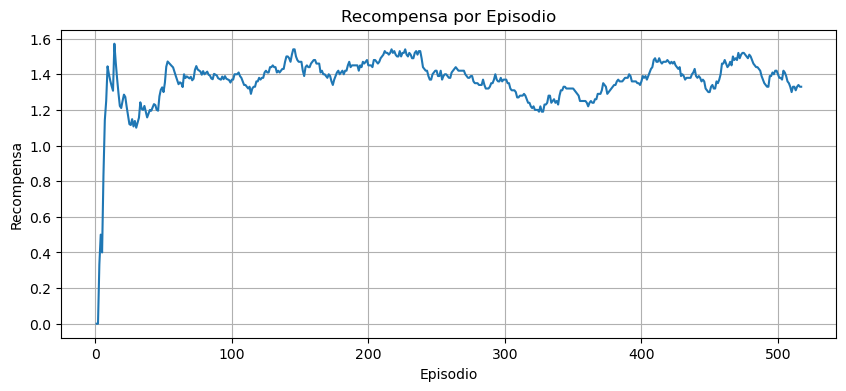

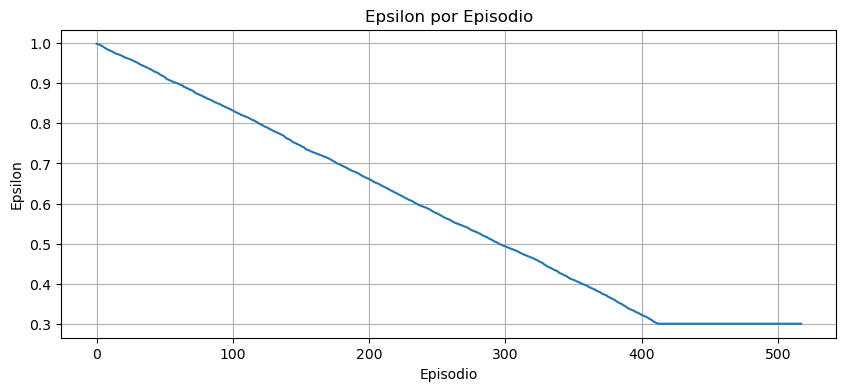

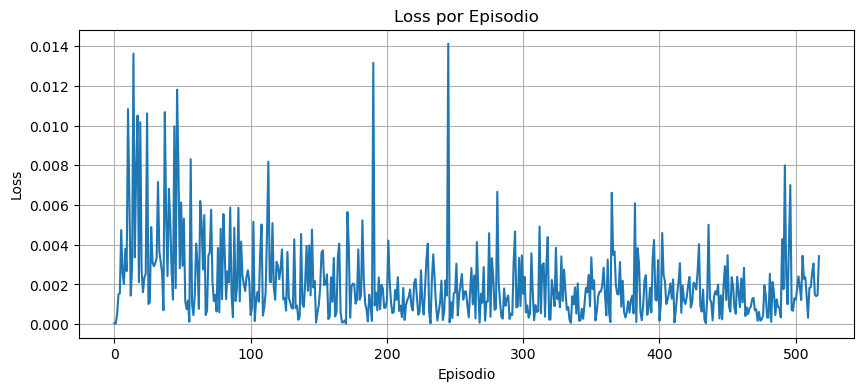

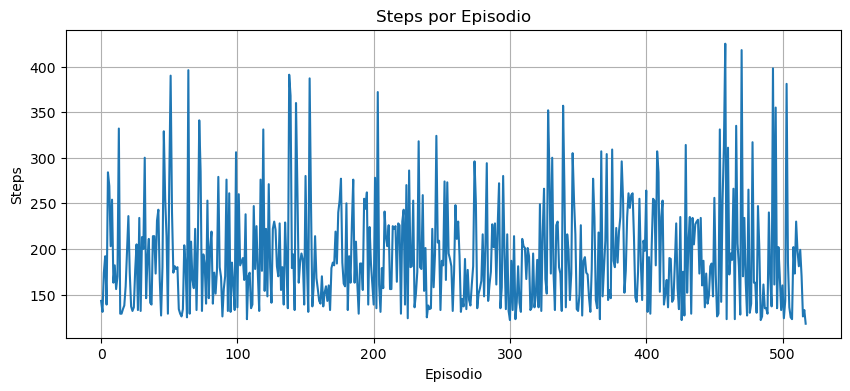

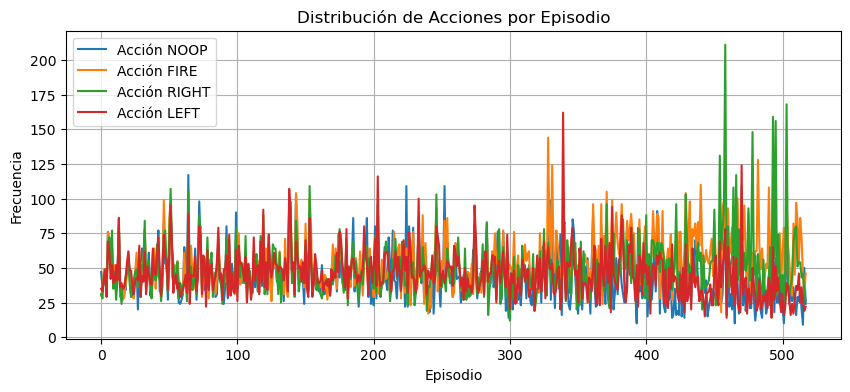

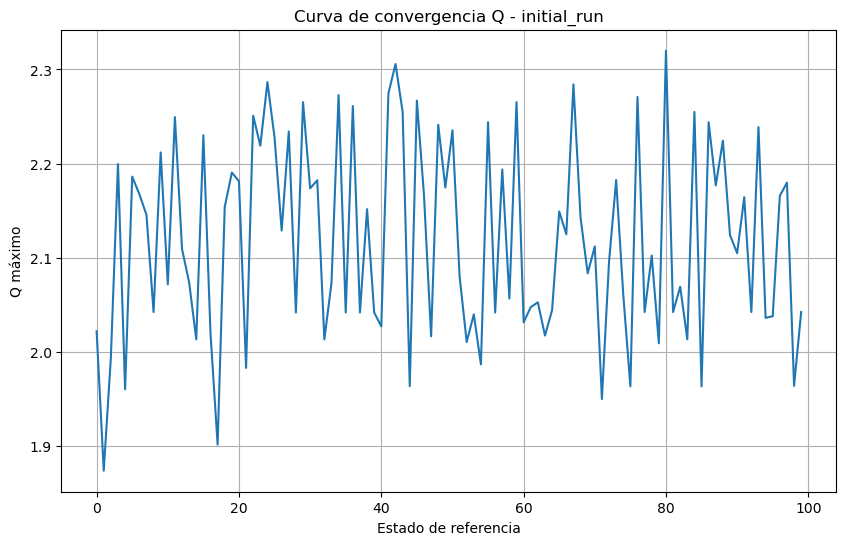

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_INITIAL_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_INITIAL_ID)

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_INITIAL_ID)
Video(video_path, embed=True, width=600)

Ejecutando agente initial_run en fase initial_run con tipo dqn
Ruta al archivo de vídeo en tu sistema de ficheros: ./videos/dqn/validation/initial_run
<TransformReward<FrameStackObservation<AtariPreprocessing<RecordVideo<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Breakout-v5>>>>>>>>


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1216428046


Recompensa total del episodio 0: 0.0
Recompensa total promedio: 0.0


# Analizamos exploración con distintos gammas


### ¿Por qué podría usarse un gamma más bajo en exploración?
Un gamma más bajo (γ cercano a 0.90–0.95) hace que el agente valore más las recompensas inmediatas y menos las futuras.
Durante la exploración, esto puede ayudar a que el agente aprenda primero a obtener recompensas rápidas y evite caminos largos y riesgosos que aún no conoce bien.
Puede hacer el aprendizaje inicial más estable, ya que el agente no se preocupa tanto por las consecuencias a largo plazo de sus acciones, que todavía no entiende bien.
Una vez que el agente tiene una idea básica del entorno, se puede aumentar gamma para que aprenda a planificar a más largo plazo.

### ¿Cuándo NO conviene bajar gamma en exploración?
Si las recompensas importantes están lejos en el tiempo (por ejemplo, solo al final del episodio), un gamma bajo puede impedir que el agente aprenda a alcanzarlas.
Si el entorno requiere planificación a largo plazo desde el principio, es mejor mantener gamma alto.

### Resumiendo:
Sí, a veces se recomienda usar gamma más bajo en exploración para facilitar el aprendizaje inicial y evitar inestabilidad.
Pero no es una regla universal: depende de la naturaleza del entorno y de las recompensas.
Muchos trabajos usan el mismo gamma alto (0.99) durante todo el entrenamiento, pero experimentar con gamma más bajo al principio puede ser útil en entornos complejos o con muchas recompensas intermedias.
¿Querés que te ayude a implementar un schedule de gamma que aumente a medida que avanza el entrenamiento?

In [ ]:
TOTAL_STEPS = 800_000
EPISODES = 10_000
EPSILON_INI = 1
EPSILON_MIN = 0.1
EPSILON_ANNEAL_STEPS = 500_000

In [ ]:
PHASE_ID_GAMMA = 'phase_gamma_0.995'
EXPLORATION_GAMMA = 0.995
execute_dqn_training_phase(PHASE_ID_GAMMA,
  reference_states,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=EXPLORATION_GAMMA
)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 500000
episode_block: 100
run_name: phase_gamma_0.995


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_gamma_0.995, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 500000, max_steps: 800000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 786/10000 [11:34<2:01:06,  1.27episode/s, reward=1.18, epsilon=0.73, steps=150007]


=== Recompensa actual: 1.18, Epsilon: 0.7299874, Total steps: 150007 ===


Entrenando:  16%|█▌        | 1560/10000 [23:27<2:31:54,  1.08s/episode, reward=1.9, epsilon=0.46, steps=3e+5]


=== Recompensa actual: 1.9, Epsilon: 0.4599712, Total steps: 300016 ===


Entrenando:  22%|██▏       | 2244/10000 [35:06<2:26:19,  1.13s/episode, reward=2.9, epsilon=0.19, steps=450208]


=== Recompensa actual: 2.9, Epsilon: 0.18962559999999995, Total steps: 450208 ===


Entrenando:  28%|██▊       | 2785/10000 [47:15<2:47:07,  1.39s/episode, reward=4.11, epsilon=0.1, steps=6e+5]


=== Recompensa actual: 4.11, Epsilon: 0.1, Total steps: 600068 ===


Entrenando:  33%|███▎      | 3293/10000 [59:25<2:50:49,  1.53s/episode, reward=4.5, epsilon=0.1, steps=750161]


=== Recompensa actual: 4.5, Epsilon: 0.1, Total steps: 750161 ===


Entrenando:  35%|███▍      | 3452/10000 [1:03:27<2:00:22,  1.10s/episode, reward=4.3, epsilon=0.1, steps=8e+5]
/content/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)



Entrenamiento detenido: se alcanzaron 800001 pasos.


In [ ]:
PHASE_ID_GAMMA = 'phase_gamma_0.95'
EXPLORATION_GAMMA = 0.95
execute_dqn_training_phase(PHASE_ID_GAMMA, reference_states, total_steps = TOTAL_STEPS,epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, gamma=EXPLORATION_GAMMA)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.95
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 500000
episode_block: 100
run_name: phase_gamma_0.95


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_gamma_0.95, con los siguientes hiperparametros:

gamma: 0.95, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 500000, max_steps: 800000




Entrenando:   8%|▊         | 765/10000 [11:20<2:30:03,  1.03episode/s, reward=1.44, epsilon=0.73, steps=150147]


=== Recompensa actual: 1.44, Epsilon: 0.7297354, Total steps: 150147 ===


Entrenando:  15%|█▍        | 1495/10000 [22:58<2:47:01,  1.18s/episode, reward=2.45, epsilon=0.459, steps=3e+5]


=== Recompensa actual: 2.45, Epsilon: 0.45949779999999996, Total steps: 300279 ===


Entrenando:  21%|██        | 2084/10000 [34:56<3:40:46,  1.67s/episode, reward=4.11, epsilon=0.189, steps=450314]


=== Recompensa actual: 4.11, Epsilon: 0.18943480000000001, Total steps: 450314 ===


Entrenando:  25%|██▌       | 2517/10000 [46:45<3:38:45,  1.75s/episode, reward=5.91, epsilon=0.1, steps=6e+5]


=== Recompensa actual: 5.91, Epsilon: 0.1, Total steps: 600126 ===


Entrenando:  29%|██▉       | 2919/10000 [58:28<4:05:23,  2.08s/episode, reward=7.2, epsilon=0.1, steps=750386]


=== Recompensa actual: 7.2, Epsilon: 0.1, Total steps: 750386 ===


Entrenando:  30%|███       | 3043/10000 [1:02:21<2:22:33,  1.23s/episode, reward=7.19, epsilon=0.1, steps=8e+5]


Entrenamiento detenido: se alcanzaron 800001 pasos.


In [ ]:
PHASE_ID_GAMMA = 'phase_gamma_0.97'
EXPLORATION_GAMMA = 0.97
agent = execute_dqn_training_phase(PHASE_ID_GAMMA,
  reference_states,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=EXPLORATION_GAMMA
)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_gamma_0.97 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.97
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 500000
episode_block: 100
run_name: phase_gamma_0.97


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_gamma_0.97, con los siguientes hiperparametros:

gamma: 0.97, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 500000, max_steps: 800000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 792/10000 [12:21<2:22:09,  1.08episode/s, reward=1.26, epsilon=0.73, steps=150007]


=== Recompensa actual: 1.26, Epsilon: 0.7299874, Total steps: 150007 ===


Entrenando:  16%|█▌        | 1578/10000 [25:08<2:29:37,  1.07s/episode, reward=1.54, epsilon=0.46, steps=3e+5]


=== Recompensa actual: 1.54, Epsilon: 0.4598812, Total steps: 300066 ===


Entrenando:  22%|██▏       | 2203/10000 [38:02<3:34:42,  1.65s/episode, reward=3.89, epsilon=0.19, steps=450151]


=== Recompensa actual: 3.89, Epsilon: 0.1897281999999999, Total steps: 450151 ===


Entrenando:  26%|██▋       | 2629/10000 [51:25<4:40:42,  2.29s/episode, reward=7, epsilon=0.1, steps=6e+5]


=== Recompensa actual: 7.0, Epsilon: 0.1, Total steps: 600202 ===


Entrenando:  30%|██▉       | 2993/10000 [1:04:36<5:01:50,  2.58s/episode, reward=7.59, epsilon=0.1, steps=750425]


=== Recompensa actual: 7.59, Epsilon: 0.1, Total steps: 750425 ===


Entrenando:  31%|███       | 3106/10000 [1:09:03<2:33:17,  1.33s/episode, reward=8.36, epsilon=0.1, steps=8e+5]


Entrenamiento detenido: se alcanzaron 800001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


## Gamma Conclusión
De las exploraciones de gamma anteriores podemos ver que:



*   Gamma = 0.995 obtuvo una recompensa promedio de 4.98
*   Gamma = 0.95 obtuvo una recompensa promedio de 6
*   Gamma = 0.97 obtuvo una recompensa promedio de 7.56

Con lo que concluimos que para la fase de exploración gamma=0.97 nos dará mejores resultados

## 2. Fase 2 de entrenamiento: Aprendizaje básico

Luego de la exploración inicial, el agente ya ha tenido contacto con el entorno y comenzó a identificar patrones básicos de acción y recompensa. En esta segunda fase, extendemos el entrenamiento a **500.000 pasos**, con el objetivo de que el agente comience a **refinar sus decisiones** y desarrolle políticas más efectivas.

Dado que en la fase anterior se obtuvieron rexompenzas muy bajos, en esta fase vamos a seguir realizando una fuerte exploracion.

Por eso, ajustamos el parámetro `epsilon` de la siguiente manera:

- `EPSILON_INI = 1`: al inicio, el agente toma decisiones completamente al azar.
- `EPSILON_MIN = 0.1`: al final del bloque, la exploración se reduce pero no significativamente, permitiendo una mayor explotación.
- `EPSILON_ANNEAL_STEPS = 500_000`: la reducción se hace de forma gradual durante la mayor parte del bloque.

Durante esta fase, **esperamos observar una mejora clara en el rendimiento**:
- Aumento progresivo en la recompensa media.
- Episodios más largos (el agente sobrevive más).
- Menor pérdida (loss), reflejando una mejor aproximación de los valores Q.

Esta fase es clave para que el agente **consolide lo aprendido** y empiece a mostrar un comportamiento más coherente, orientado a maximizar la recompensa.

In [ ]:
# gamma 0.97
EXPLORATION_GAMMA = 0.97
print(f"net a cargar con PHASE_ID: {PHASE_INITIAL_ID}")
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_INITIAL_ID)

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: initial_run
PHASE_ID: phase_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.1, EPSILON_ANNEAL_STEPS: 1500000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-initial_run.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
  PHASE_ID,
  reference_states,
  loadPath=LOAD_NET_PATH,
  total_steps = TOTAL_STEPS,
  episodes = EPISODES,
  epsilon_i = EPSILON_INI,
  epsilon_f = EPSILON_MIN,
  epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
  gamma=EXPLORATION_GAMMA
)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-initial_run.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.97
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 1500000
episode_block: 100
run_name: phase_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_2, con los siguientes hiperparametros:

gamma: 0.97, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 1500000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 786/10000 [11:34<2:46:40,  1.09s/episode, reward=1.32, epsilon=0.91, steps=150115]


=== Recompensa actual: 1.32, Epsilon: 0.909931, Total steps: 150115 ===


Entrenando:  16%|█▌        | 1572/10000 [23:17<2:10:17,  1.08episode/s, reward=1.56, epsilon=0.82, steps=3e+5]


=== Recompensa actual: 1.56, Epsilon: 0.8199796, Total steps: 300034 ===


Entrenando:  23%|██▎       | 2258/10000 [35:05<2:20:37,  1.09s/episode, reward=2.68, epsilon=0.73, steps=450046]


=== Recompensa actual: 2.68, Epsilon: 0.7299724, Total steps: 450046 ===


Entrenando:  29%|██▊       | 2853/10000 [46:46<2:13:18,  1.12s/episode, reward=3.37, epsilon=0.64, steps=6e+5]


=== Recompensa actual: 3.37, Epsilon: 0.6398524, Total steps: 600246 ===


Entrenando:  34%|███▎      | 3374/10000 [58:32<2:35:14,  1.41s/episode, reward=4.34, epsilon=0.55, steps=750146]


=== Recompensa actual: 4.34, Epsilon: 0.5499124, Total steps: 750146 ===


Entrenando:  38%|███▊      | 3834/10000 [1:10:24<2:19:19,  1.36s/episode, reward=5.61, epsilon=0.46, steps=9e+5]


=== Recompensa actual: 5.61, Epsilon: 0.45994899999999994, Total steps: 900085 ===


Entrenando:  42%|████▏     | 4223/10000 [1:22:08<3:14:07,  2.02s/episode, reward=7.15, epsilon=0.37, steps=1050367]


=== Recompensa actual: 7.15, Epsilon: 0.3697798, Total steps: 1050367 ===


Entrenando:  46%|████▌     | 4579/10000 [1:33:43<3:19:18,  2.21s/episode, reward=8.19, epsilon=0.28, steps=1.2e+6]


=== Recompensa actual: 8.19, Epsilon: 0.27978879999999995, Total steps: 1200352 ===


Entrenando:  49%|████▉     | 4894/10000 [1:45:27<4:01:03,  2.83s/episode, reward=9.81, epsilon=0.19, steps=1350252]


=== Recompensa actual: 9.81, Epsilon: 0.18984880000000004, Total steps: 1350252 ===


Entrenando:  52%|█████▏    | 5187/10000 [1:57:21<3:12:47,  2.40s/episode, reward=10.6, epsilon=0.1, steps=1.5e+6]


=== Recompensa actual: 10.56, Epsilon: 0.1, Total steps: 1500215 ===


Entrenando:  55%|█████▍    | 5455/10000 [2:09:38<3:14:07,  2.56s/episode, reward=10.8, epsilon=0.1, steps=1650252]


=== Recompensa actual: 10.78, Epsilon: 0.1, Total steps: 1650252 ===


Entrenando:  57%|█████▋    | 5719/10000 [2:22:02<3:32:54,  2.98s/episode, reward=11.9, epsilon=0.1, steps=1.8e+6]


=== Recompensa actual: 11.94, Epsilon: 0.1, Total steps: 1800424 ===


Entrenando:  60%|█████▉    | 5977/10000 [2:34:19<2:56:14,  2.63s/episode, reward=12.4, epsilon=0.1, steps=1950419]


=== Recompensa actual: 12.41, Epsilon: 0.1, Total steps: 1950419 ===


Entrenando:  61%|██████    | 6062/10000 [2:38:21<1:42:52,  1.57s/episode, reward=12.5, epsilon=0.1, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Visualizar métricas

Datos cargados de metrics/dqn/metrics_phase_2.npz: [[ 97  98  81  88]
 [ 41  41  37  46]
 [ 52  51  62  51]
 ...
 [ 96 161 187 165]
 [ 28  75  39  71]
 [ 23  48  43  60]]


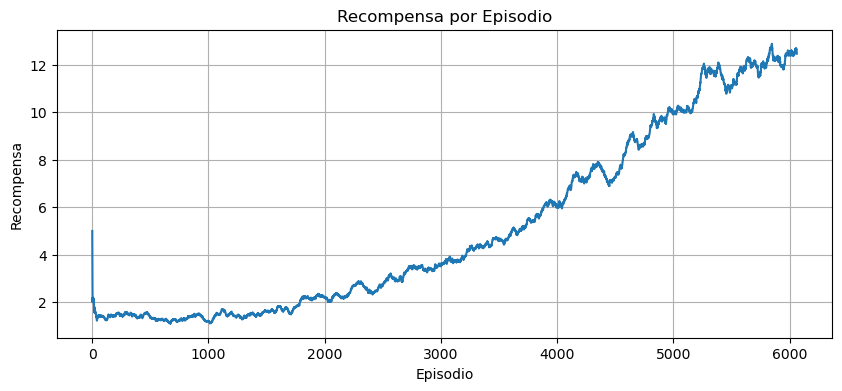

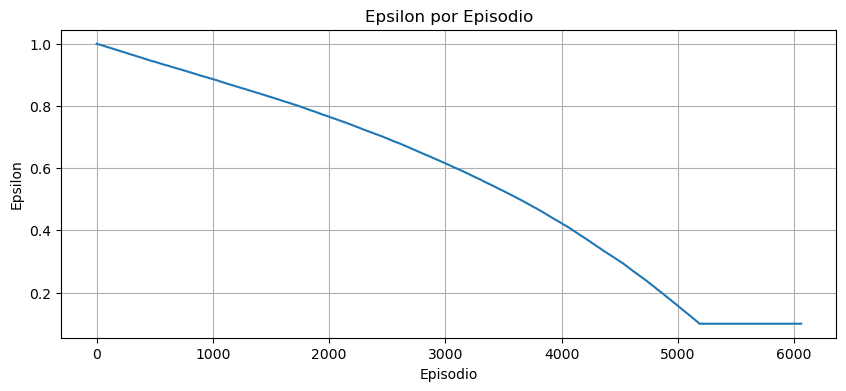

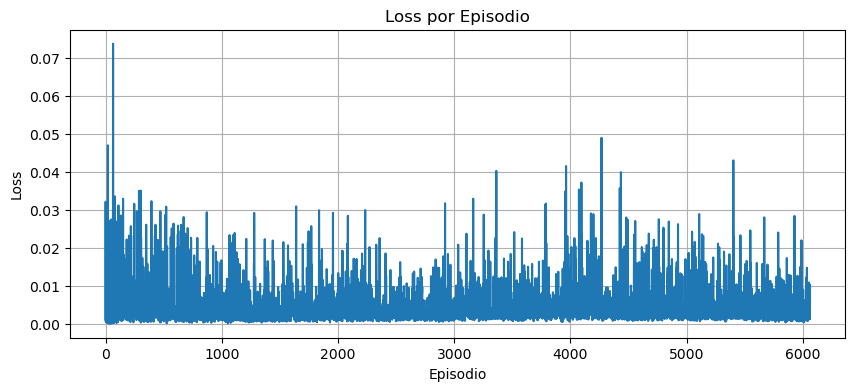

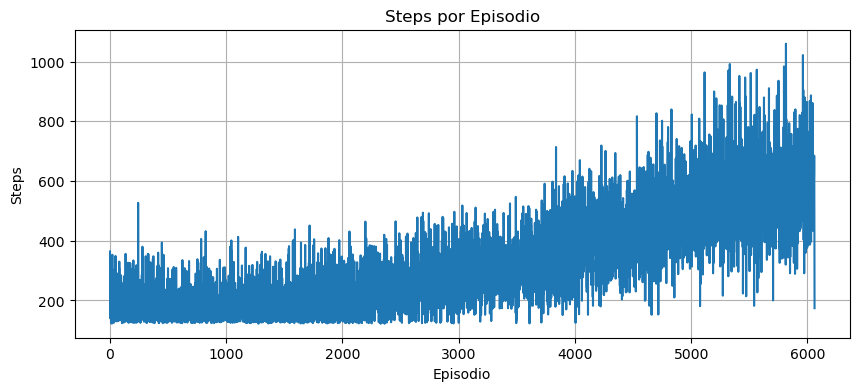

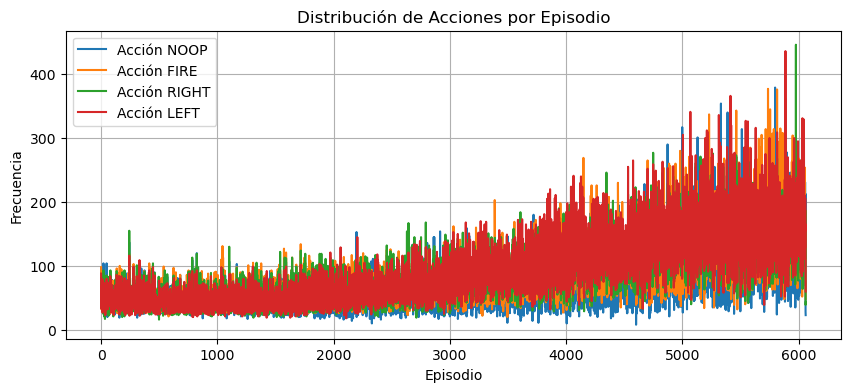

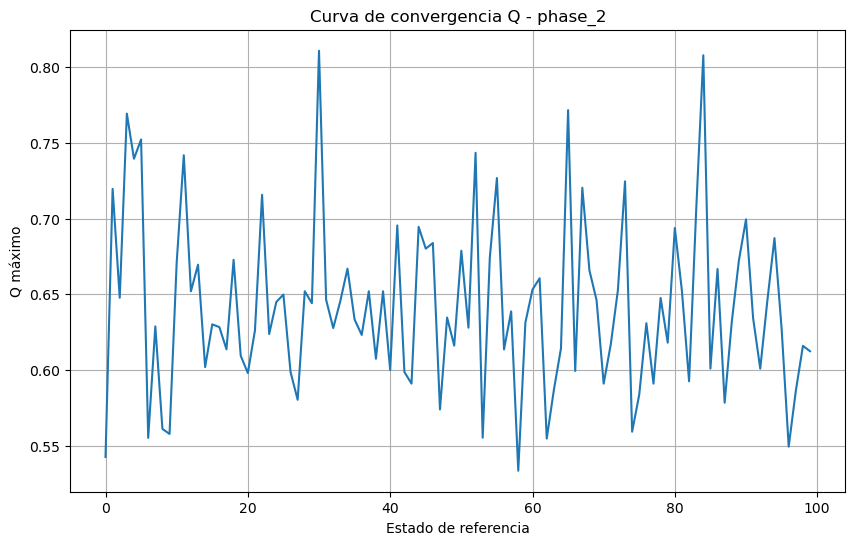

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_2_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_2_ID)

### Phase 2 - exploración

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_ID)
Video(video_path, embed=True, width=600)

Recompensa total del episodio 0: 12.0
Recompensa total promedio: 12.0


## 3. Consolidación y estabilidad de la política

Después de haber explorado el entorno y refinado algunas estrategias efectivas, el agente ya no actúa completamente a ciegas. Ha empezado a desarrollar comportamientos útiles, y ahora es momento de **consolidar** ese conocimiento.

En esta tercera fase, extendemos el entrenamiento a **2.000.000 de pasos**, lo que permite al agente mejorar la consistencia de sus decisiones y adaptarse mejor a situaciones complejas del entorno.

En esta etapa, la exploración es mucho más moderada. El agente debe confiar cada vez más en su política aprendida, pero aún se le permite cierta libertad para seguir ajustando su comportamiento.

Configuramos el parámetro `epsilon` así:

- `EPSILON_INI = 0.1`: partimos de una exploración baja, porque el agente ya tiene una base aprendida.
- `EPSILON_MIN = 0.01`: dejamos una pequeña ventana de exploración por si aún puede descubrir mejores acciones.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el `epsilon` decae lentamente, permitiendo una transición gradual hacia la explotación.

Durante esta fase **esperamos observar mejoras más claras y sostenidas** en las métricas:
- La recompensa promedio por episodio debería aumentar.
- El `loss` debería estabilizarse en valores más bajos y menos ruidosos.
- El número de pasos por episodio debería incrementarse, señal de que el agente sobrevive y actúa con mayor efectividad.

Esta fase marca el paso de un comportamiento inestable a una política más **madura y confiable**, donde el agente deja de aprender por prueba y error, y empieza a actuar con intención.

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_2
PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_2.dat


In [ ]:
# Creamos, cargamos pesos anteriores y entrenemos el agente
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_2.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.1
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_3
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.1, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   3%|▎         | 334/10000 [12:07<6:28:29,  2.41s/episode, reward=10.6, epsilon=0.0865, steps=150496]


=== Recompensa actual: 10.61, Epsilon: 0.08645536000000001, Total steps: 150496 ===


Entrenando:   6%|▌         | 606/10000 [24:13<7:16:34,  2.79s/episode, reward=12.3, epsilon=0.073, steps=3e+5]


=== Recompensa actual: 12.28, Epsilon: 0.07297435, Total steps: 300285 ===


Entrenando:   9%|▊         | 851/10000 [36:11<9:03:28,  3.56s/episode, reward=14.2, epsilon=0.0594, steps=450584]


=== Recompensa actual: 14.2, Epsilon: 0.059447440000000004, Total steps: 450584 ===


Entrenando:  11%|█         | 1091/10000 [48:09<7:31:15,  3.04s/episode, reward=13.8, epsilon=0.046, steps=6e+5]


=== Recompensa actual: 13.77, Epsilon: 0.045996220000000004, Total steps: 600042 ===


Entrenando:  13%|█▎        | 1315/10000 [1:00:10<8:55:03,  3.70s/episode, reward=15.3, epsilon=0.0324, steps=750784]


=== Recompensa actual: 15.26, Epsilon: 0.032429440000000004, Total steps: 750784 ===


Entrenando:  15%|█▌        | 1537/10000 [1:12:00<8:25:16,  3.58s/episode, reward=15.8, epsilon=0.0189, steps=900657]


=== Recompensa actual: 15.82, Epsilon: 0.01894087, Total steps: 900657 ===


Entrenando:  18%|█▊        | 1754/10000 [1:23:50<7:16:45,  3.18s/episode, reward=15.7, epsilon=0.01, steps=1050423]


=== Recompensa actual: 15.7, Epsilon: 0.01, Total steps: 1050423 ===


Entrenando:  20%|█▉        | 1968/10000 [1:35:35<6:44:51,  3.02s/episode, reward=16.3, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 16.31, Epsilon: 0.01, Total steps: 1200082 ===


Entrenando:  22%|██▏       | 2166/10000 [1:47:35<7:46:43,  3.57s/episode, reward=18.9, epsilon=0.01, steps=1350271]


=== Recompensa actual: 18.86, Epsilon: 0.01, Total steps: 1350271 ===


Entrenando:  24%|██▎       | 2362/10000 [1:59:21<9:57:50,  4.70s/episode, reward=18.4, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.36, Epsilon: 0.01, Total steps: 1500015 ===


Entrenando:  26%|██▌       | 2567/10000 [2:11:15<6:16:26,  3.04s/episode, reward=17.1, epsilon=0.01, steps=1650285]


=== Recompensa actual: 17.05, Epsilon: 0.01, Total steps: 1650285 ===


Entrenando:  28%|██▊       | 2770/10000 [2:23:02<6:21:38,  3.17s/episode, reward=17.2, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 17.24, Epsilon: 0.01, Total steps: 1800129 ===


Entrenando:  30%|██▉       | 2975/10000 [2:35:00<6:28:57,  3.32s/episode, reward=17.5, epsilon=0.01, steps=1950351]


=== Recompensa actual: 17.48, Epsilon: 0.01, Total steps: 1950351 ===


Entrenando:  30%|███       | 3039/10000 [2:39:05<6:04:23,  3.14s/episode, reward=18.1, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Visualizar métricas

Datos cargados de metrics/dqn/metrics_phase_3.npz: [[107  74  47 179]
 [ 41  13  85 251]
 [ 50  64  84  96]
 ...
 [322 150  92 124]
 [330 230 121 150]
 [370 205 121 166]]


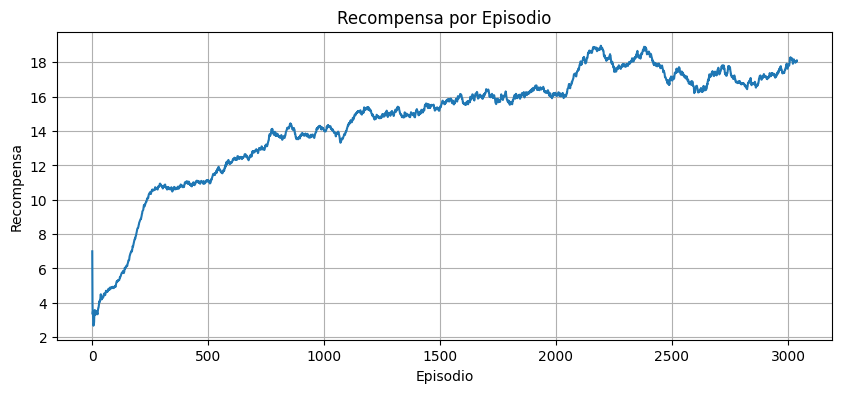

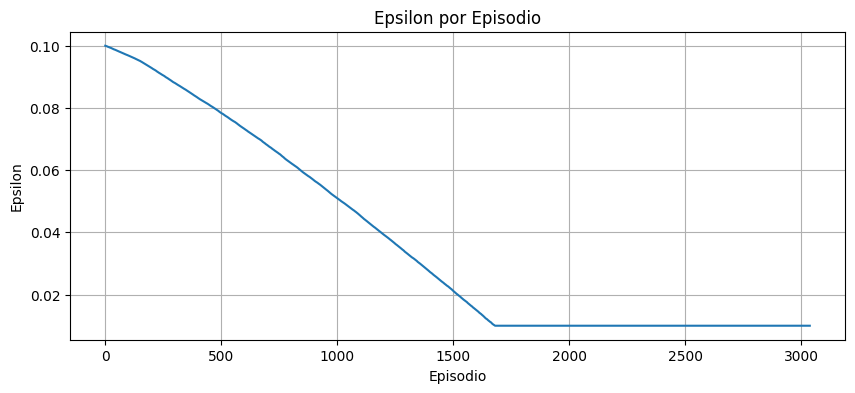

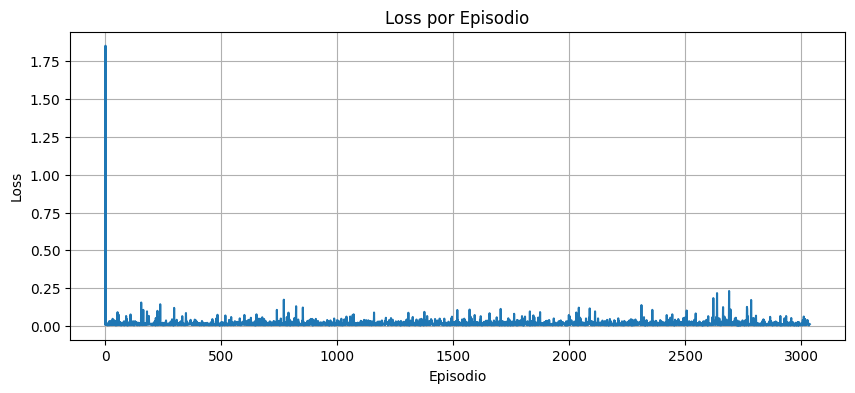

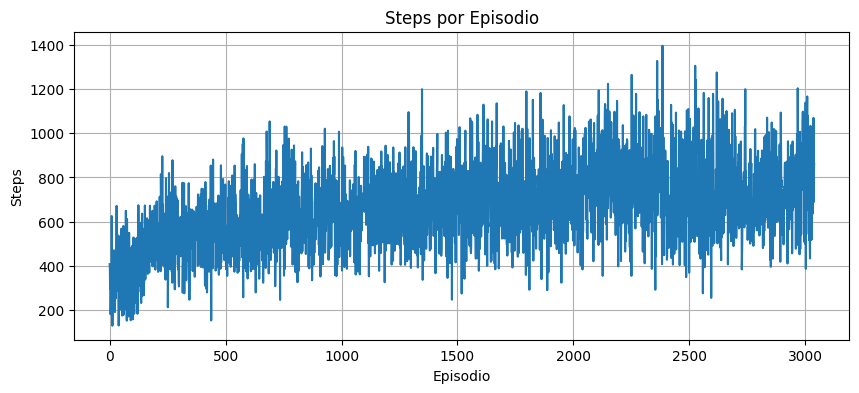

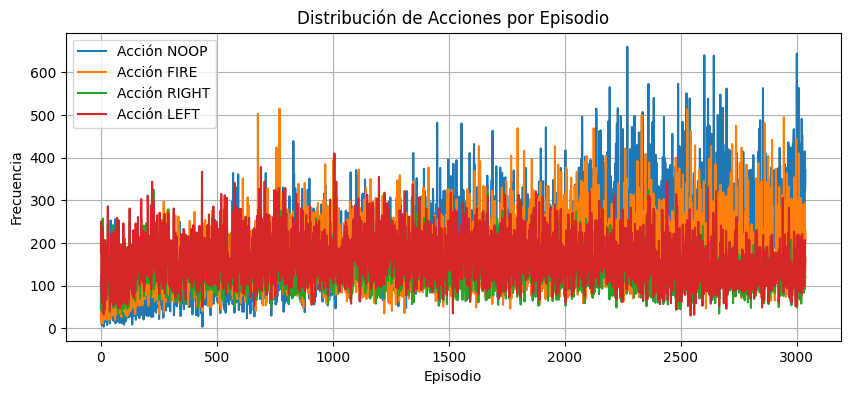

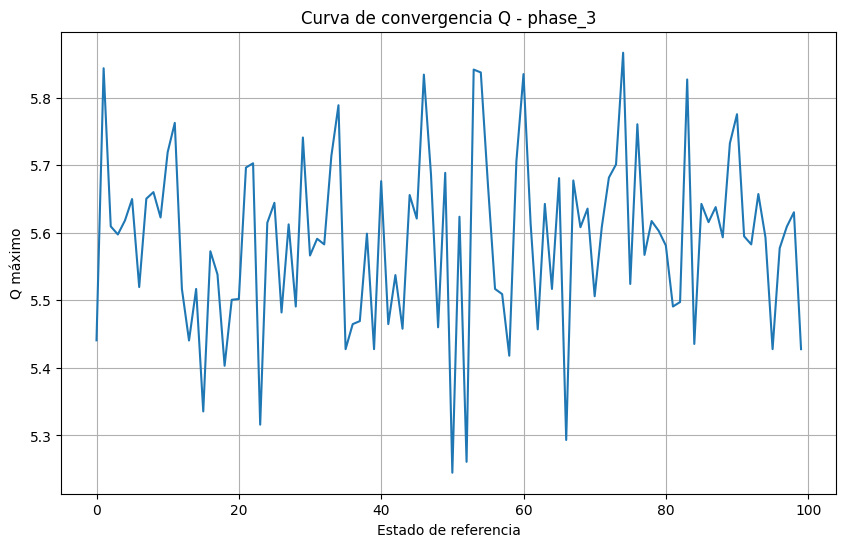

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_3_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_3_ID)

### Evaluar el juego del ambiente Phase 3

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_3_ID)
Video(video_path, embed=True, width=600)

Recompensa total del episodio 0: 21.0
Recompensa total promedio: 21.0


## Observaciones phase 3

Aunque el agente aprendio una politica que mejora al agente de la fase dos, podemos ver que luego del episodio 2000 el agente comienza a estancarse, esto puede deverse a una exploracion insuficiente, vemos que se empieza a estancar con epsilon = 0.01, o sea que casi no explora. Pero tambien puede deberse a que el agente experimenta un sobreajuste a una política subóptima, es decir, aprende una estrategia que ofrece un rendimiento aceptable pero no óptimo, y termina atrapado en ella sin explorar alternativas que podrían generar mejores resultados. Para descartal la primer hipotesis vamos a hacer otro entrenamiento con mas exploracion, para ver si mejora.


### Exploracion en fase 3

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_3_ID)
print(f"net a cargar con PHASE_ID: {PHASE_3_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_3
PHASE_ID: phase_3_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.5, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3.dat


In [ ]:
# Creamos, cargamos pesos anteriores y entrenemos el agente
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_3.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.5
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_3_2
Use prioritized memory: False


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.5, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   4%|▍         | 391/10000 [11:02<5:52:38,  2.20s/episode, reward=7.87, epsilon=0.426, steps=150016]


=== Recompensa actual: 7.87, Epsilon: 0.42649216, Total steps: 150016 ===


Entrenando:   7%|▋         | 728/10000 [22:10<6:25:14,  2.49s/episode, reward=8.74, epsilon=0.353, steps=3e+5]


=== Recompensa actual: 8.74, Epsilon: 0.35278244000000003, Total steps: 300444 ===


Entrenando:  10%|█         | 1040/10000 [33:18<5:00:28,  2.01s/episode, reward=9.35, epsilon=0.279, steps=450117]


=== Recompensa actual: 9.35, Epsilon: 0.27944267, Total steps: 450117 ===


Entrenando:  13%|█▎        | 1318/10000 [44:32<6:08:24,  2.55s/episode, reward=11.5, epsilon=0.206, steps=6e+5]


=== Recompensa actual: 11.47, Epsilon: 0.20582310999999998, Total steps: 600361 ===


Entrenando:  16%|█▌        | 1572/10000 [55:53<6:40:13,  2.85s/episode, reward=13.1, epsilon=0.132, steps=750383]


=== Recompensa actual: 13.13, Epsilon: 0.13231232999999998, Total steps: 750383 ===


Entrenando:  18%|█▊        | 1815/10000 [1:07:17<6:26:54,  2.84s/episode, reward=14.4, epsilon=0.0587, steps=900568]


=== Recompensa actual: 14.44, Epsilon: 0.05872168, Total steps: 900568 ===


Entrenando:  20%|██        | 2036/10000 [1:18:38<8:33:31,  3.87s/episode, reward=14.9, epsilon=0.01, steps=1050418]


=== Recompensa actual: 14.95, Epsilon: 0.01, Total steps: 1050418 ===


Entrenando:  22%|██▏       | 2243/10000 [1:30:05<6:57:38,  3.23s/episode, reward=16.2, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 16.22, Epsilon: 0.01, Total steps: 1200120 ===


Entrenando:  25%|██▍       | 2451/10000 [1:41:29<6:34:46,  3.14s/episode, reward=17.6, epsilon=0.01, steps=1350011]


=== Recompensa actual: 17.56, Epsilon: 0.01, Total steps: 1350011 ===


Entrenando:  27%|██▋       | 2655/10000 [1:52:59<7:22:00,  3.61s/episode, reward=18.9, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.94, Epsilon: 0.01, Total steps: 1500605 ===


Entrenando:  29%|██▊       | 2855/10000 [2:04:18<6:37:26,  3.34s/episode, reward=17.8, epsilon=0.01, steps=1650604]


=== Recompensa actual: 17.81, Epsilon: 0.01, Total steps: 1650604 ===


Entrenando:  31%|███       | 3056/10000 [2:15:43<6:40:17,  3.46s/episode, reward=17.3, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 17.28, Epsilon: 0.01, Total steps: 1800005 ===


Entrenando:  33%|███▎      | 3258/10000 [2:27:04<5:49:52,  3.11s/episode, reward=17.3, epsilon=0.01, steps=1950042]


=== Recompensa actual: 17.29, Epsilon: 0.01, Total steps: 1950042 ===


Entrenando:  33%|███▎      | 3324/10000 [2:30:51<5:03:00,  2.72s/episode, reward=17.8, epsilon=0.01, steps=2e+6]
/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)



Entrenamiento detenido: se alcanzaron 2000001 pasos.


Datos cargados de metrics/dqn/metrics_phase_3_2.npz: [[ 91  91  79  85]
 [ 30  88  30  34]
 [ 83 109 123 121]
 ...
 [332  80 132 129]
 [399 128 102 176]
 [ 16   7   3   6]]


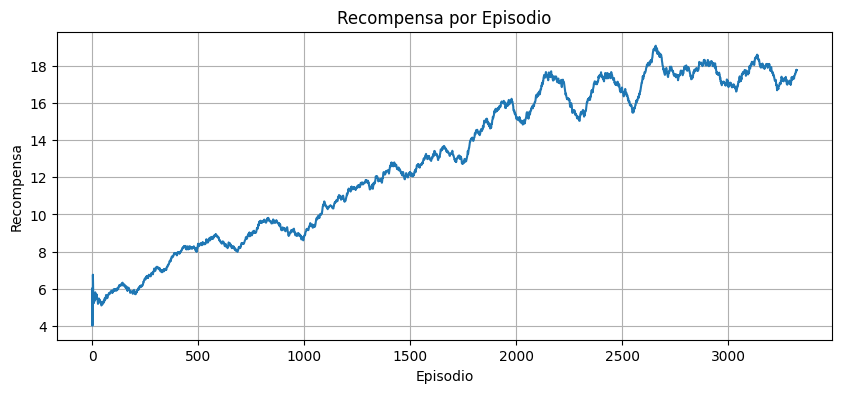

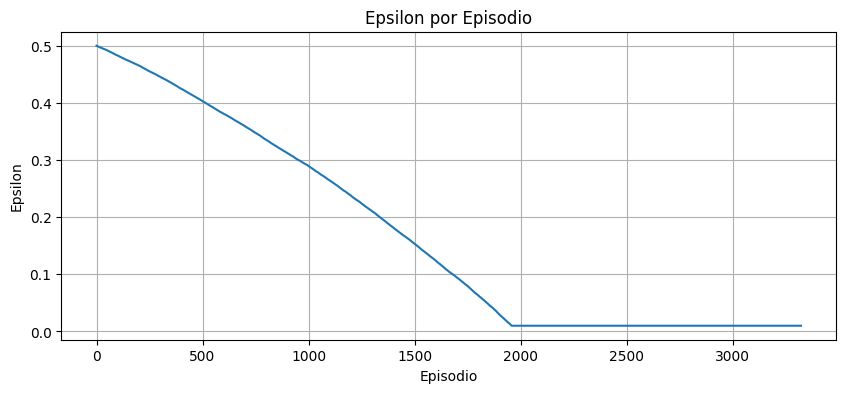

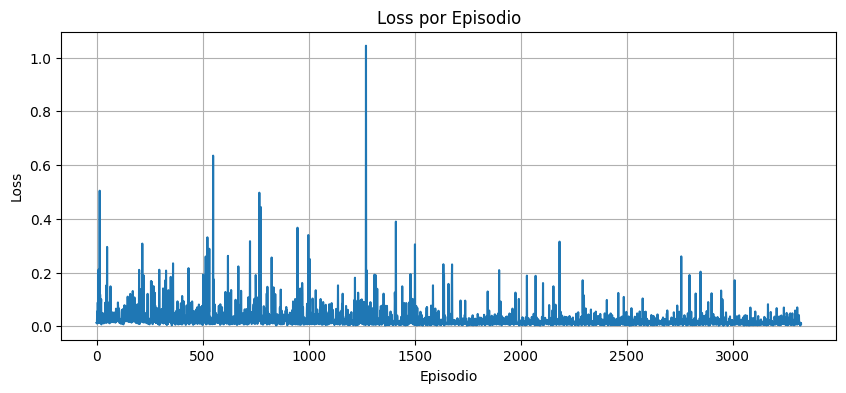

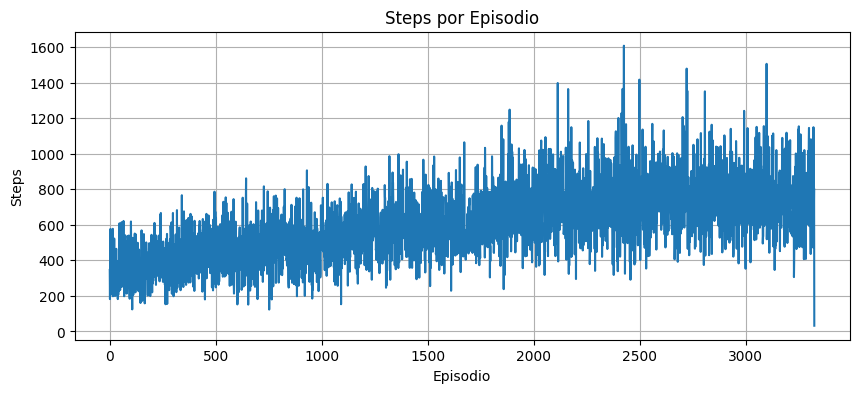

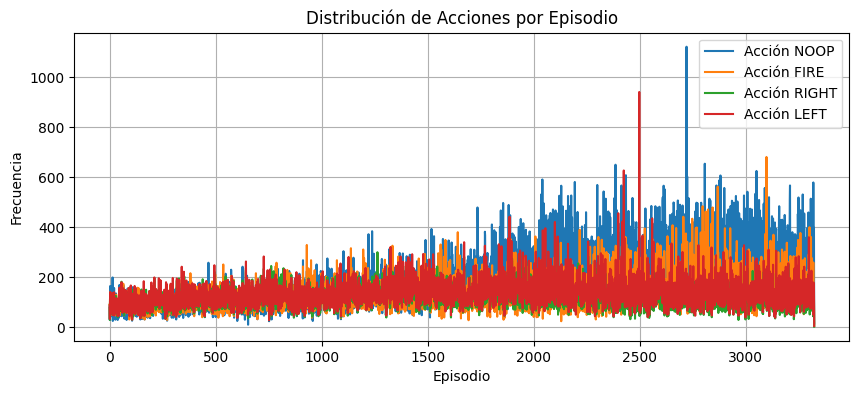

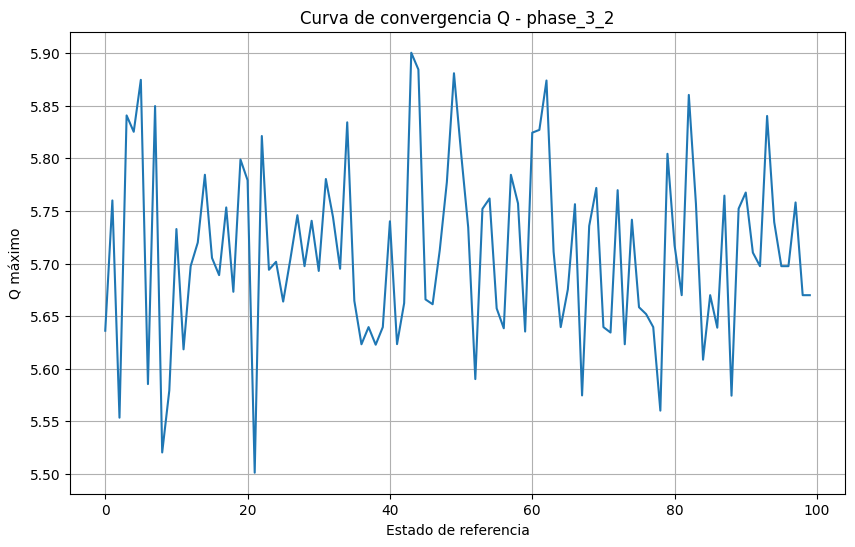

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_3_2_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_3_2_ID)

In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_3_2_ID)
Video(video_path, embed=True, width=600)

Recompensa total del episodio 0: 23.0
Recompensa total promedio: 23.0


## 4. Entrenamiento largo

Luego de consolidar una política estable, el agente está listo para enfrentar su fase más extensa: **un entrenamiento de 6.000.000 pasos**. Esta etapa tiene como objetivo principal **refinar los últimos detalles de su comportamiento**, buscando alcanzar un rendimiento óptimo y robusto.

Durante esta fase, la exploración es mínima:

- `EPSILON_INI = 0.05`: el agente comienza confiando casi por completo en su política aprendida.
- `EPSILON_MIN = 0.01`: se conserva un margen muy pequeño de exploración para evitar caer en políticas rígidas o locales.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el descenso es lento y progresivo, asegurando una transición estable hacia la explotación total.

En este punto, el agente ya sabe jugar razonablemente bien. El objetivo no es descubrir nuevas estrategias, sino **mejorar la consistencia, evitar errores esporádicos** y adaptarse a variaciones sutiles del entorno.

En la gráfica de pérdida (loss), esperamos observar:

- Valores bajos de pérdida sostenida, con menor varianza.
- Posibles picos aislados, que reflejan casos complejos o poco frecuentes.
- Una mayor proporción de episodios con `loss` cercano a cero.

Esta etapa representa el momento en que el agente deja de aprender con grandes saltos y empieza a **pulir detalles**, como quien afina los últimos toques antes de una presentación.

Al final de esta fase, esperamos ver un comportamiento mucho más **confiado, efectivo y repetible**, listo para ser evaluado sin exploración y con resultados competitivos.

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_3_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_3_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

net a cargar con PHASE_ID: initial_run
PHASE_ID: phase_4_1, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.05, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3.dat
Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_3.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.05
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_4_1


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_4_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_1, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.05, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 221/10000 [11:35<8:41:39,  3.20s/episode, reward=16.4, epsilon=0.044, steps=150152]


=== Recompensa actual: 16.38, Epsilon: 0.043993920000000006, Total steps: 150152 ===


Entrenando:   4%|▍         | 427/10000 [23:33<10:16:28,  3.86s/episode, reward=17.4, epsilon=0.038, steps=3e+5]


=== Recompensa actual: 17.37, Epsilon: 0.03799604, Total steps: 300099 ===


Entrenando:   6%|▋         | 628/10000 [35:26<7:41:45,  2.96s/episode, reward=18.5, epsilon=0.032, steps=450329]


=== Recompensa actual: 18.48, Epsilon: 0.03198684, Total steps: 450329 ===


Entrenando:   8%|▊         | 830/10000 [46:57<8:50:08,  3.47s/episode, reward=17.9, epsilon=0.026, steps=6e+5]


=== Recompensa actual: 17.95, Epsilon: 0.025983320000000004, Total steps: 600417 ===


Entrenando:  10%|█         | 1022/10000 [58:34<8:49:44,  3.54s/episode, reward=18.4, epsilon=0.02, steps=750282]


=== Recompensa actual: 18.38, Epsilon: 0.01998872, Total steps: 750282 ===


Entrenando:  12%|█▏        | 1224/10000 [1:10:05<8:42:40,  3.57s/episode, reward=17.8, epsilon=0.014, steps=9e+5] 


=== Recompensa actual: 17.83, Epsilon: 0.013980720000000002, Total steps: 900482 ===


Entrenando:  14%|█▍        | 1418/10000 [1:21:36<8:14:32,  3.46s/episode, reward=18.7, epsilon=0.01, steps=1050488]


=== Recompensa actual: 18.67, Epsilon: 0.01, Total steps: 1050488 ===


Entrenando:  16%|█▌        | 1603/10000 [1:33:18<10:31:10,  4.51s/episode, reward=19.4, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 19.41, Epsilon: 0.01, Total steps: 1200835 ===


Entrenando:  18%|█▊        | 1789/10000 [1:44:49<8:24:34,  3.69s/episode, reward=19.4, epsilon=0.01, steps=1350627]


=== Recompensa actual: 19.41, Epsilon: 0.01, Total steps: 1350627 ===


Entrenando:  20%|█▉        | 1981/10000 [1:56:12<8:25:49,  3.78s/episode, reward=18.6, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.56, Epsilon: 0.01, Total steps: 1500120 ===


Entrenando:  22%|██▏       | 2164/10000 [2:07:55<7:20:53,  3.38s/episode, reward=20.1, epsilon=0.01, steps=1650496]


=== Recompensa actual: 20.09, Epsilon: 0.01, Total steps: 1650496 ===


Entrenando:  23%|██▎       | 2341/10000 [2:19:30<7:16:04,  3.42s/episode, reward=19.7, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 19.71, Epsilon: 0.01, Total steps: 1800675 ===


Entrenando:  25%|██▌       | 2523/10000 [2:31:12<7:09:39,  3.45s/episode, reward=19.4, epsilon=0.01, steps=1950009]


=== Recompensa actual: 19.44, Epsilon: 0.01, Total steps: 1950009 ===


Entrenando:  26%|██▌       | 2584/10000 [2:35:07<7:25:11,  3.60s/episode, reward=19.4, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_4_1_ID)
print(f"net a cargar con PHASE_ID: {PHASE_4_1_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_4_2
PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_4_1.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

net a cargar con PHASE_ID: phase_4_1
PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_4_1.dat
Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_4_1.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
episode_block: 100
run_name: phase_4_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.01, epsilon_f: 0.01, epsilon_anneal_steps: 2000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 205/10000 [13:28<13:13:17,  4.86s/episode, reward=17.8, epsilon=0.01, steps=150470]


=== Recompensa actual: 17.75, Epsilon: 0.01, Total steps: 150470 ===


Entrenando:   4%|▍         | 392/10000 [27:00<11:40:45,  4.38s/episode, reward=20, epsilon=0.01, steps=3e+5]


=== Recompensa actual: 19.99, Epsilon: 0.01, Total steps: 300328 ===


Entrenando:   6%|▌         | 585/10000 [40:27<10:54:37,  4.17s/episode, reward=18.6, epsilon=0.01, steps=450693]


=== Recompensa actual: 18.59, Epsilon: 0.01, Total steps: 450693 ===


Entrenando:   8%|▊         | 768/10000 [53:47<12:32:17,  4.89s/episode, reward=19.5, epsilon=0.01, steps=6e+5]


=== Recompensa actual: 19.49, Epsilon: 0.01, Total steps: 600252 ===


Entrenando:   9%|▉         | 948/10000 [1:07:35<10:13:50,  4.07s/episode, reward=19.8, epsilon=0.01, steps=750545]


=== Recompensa actual: 19.78, Epsilon: 0.01, Total steps: 750545 ===


Entrenando:  11%|█▏        | 1133/10000 [1:21:10<10:04:38,  4.09s/episode, reward=20.1, epsilon=0.01, steps=9e+5]


=== Recompensa actual: 20.08, Epsilon: 0.01, Total steps: 900450 ===


Entrenando:  13%|█▎        | 1313/10000 [1:34:48<8:45:38,  3.63s/episode, reward=19.8, epsilon=0.01, steps=1050563]


=== Recompensa actual: 19.84, Epsilon: 0.01, Total steps: 1050563 ===


Entrenando:  15%|█▌        | 1501/10000 [1:48:12<10:04:56,  4.27s/episode, reward=19.1, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 19.1, Epsilon: 0.01, Total steps: 1200817 ===


Entrenando:  17%|█▋        | 1695/10000 [2:01:38<9:19:26,  4.04s/episode, reward=18.3, epsilon=0.01, steps=1350257] 


=== Recompensa actual: 18.32, Epsilon: 0.01, Total steps: 1350257 ===


Entrenando:  19%|█▉        | 1883/10000 [2:14:59<10:03:44,  4.46s/episode, reward=19.4, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 19.35, Epsilon: 0.01, Total steps: 1500696 ===


Entrenando:  21%|██        | 2065/10000 [2:28:19<12:28:33,  5.66s/episode, reward=20, epsilon=0.01, steps=1651049]


=== Recompensa actual: 19.96, Epsilon: 0.01, Total steps: 1651049 ===


Entrenando:  22%|██▎       | 2250/10000 [2:41:39<11:03:07,  5.13s/episode, reward=19.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 19.78, Epsilon: 0.01, Total steps: 1800280 ===


Entrenando:  24%|██▍       | 2433/10000 [2:55:05<9:11:16,  4.37s/episode, reward=19.2, epsilon=0.01, steps=1950531]


=== Recompensa actual: 19.17, Epsilon: 0.01, Total steps: 1950531 ===


Entrenando:  25%|██▍       | 2490/10000 [2:59:32<9:01:31,  4.33s/episode, reward=20.1, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


In [ ]:
from load_and_evaluate import  load_dqn_agent
VIDEO_FOLDER = f"./videos/dqn_training_{PHASE_4_2}"
env = create_env(video_folder=VIDEO_FOLDER)
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_4_2_ID)
dqn_agent = load_dqn_agent(env,
    loadPath=LOAD_NET_PATH,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    gamma=GAMMA,
    epsilon_i=EPSILON_INI,
    epsilon_f=EPSILON_MIN,
    epsilon_anneal_steps= EPSILON_ANNEAL_STEPS,
    episode_block=EPISODE_BLOCK,
    run_name=PHASE_4_2_ID
)

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_4_2.dat
buffer_size: 30000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
episode_block: 100
run_name: phase_4_2


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn_training_phase_4_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
VALIDATION_VIDEO_FOLDER = f'./videos/dqn_validation/{PHASE_4_2_ID}'
# creste env
env = create_env(video_folder=VALIDATION_VIDEO_FOLDER)
dqn_agent.play(env, episodes=1)

env.close()

# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = f"{VALIDATION_VIDEO_FOLDER}/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn_validation/phase_4_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recompensa total del episodio 0: 28.0
Recompensa total promedio: 28.0


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_4_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_4_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_4_2
PHASE_ID: phase_4_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.01, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 2000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_4_2.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/phase_4_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_4_2.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.01
epsilon_f: 0.01
epsilon_anneal_steps: 2000000
episode_block: 100
run_name: phase_4_2


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_4_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.01, epsilon_f: 0.01, epsilon_anneal_steps: 2000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 193/10000 [13:06<11:35:10,  4.25s/episode, reward=18.9, epsilon=0.01, steps=150763]


=== Recompensa actual: 18.94, Epsilon: 0.01, Total steps: 150763 ===


Entrenando:   4%|▍         | 380/10000 [25:55<11:32:12,  4.32s/episode, reward=19.7, epsilon=0.01, steps=3e+5]


=== Recompensa actual: 19.69, Epsilon: 0.01, Total steps: 300107 ===


Entrenando:   6%|▌         | 560/10000 [39:07<12:10:45,  4.64s/episode, reward=20.7, epsilon=0.01, steps=450235]


=== Recompensa actual: 20.7, Epsilon: 0.01, Total steps: 450235 ===


Entrenando:   7%|▋         | 736/10000 [52:06<11:36:32,  4.51s/episode, reward=20.5, epsilon=0.01, steps=600728]


=== Recompensa actual: 20.5, Epsilon: 0.01, Total steps: 600728 ===


Entrenando:   9%|▉         | 917/10000 [1:04:57<11:36:10,  4.60s/episode, reward=20.1, epsilon=0.01, steps=750070]


=== Recompensa actual: 20.13, Epsilon: 0.01, Total steps: 750070 ===


Entrenando:  11%|█         | 1100/10000 [1:17:57<10:22:18,  4.20s/episode, reward=20.2, epsilon=0.01, steps=9e+5]


=== Recompensa actual: 20.2, Epsilon: 0.01, Total steps: 900048 ===


Entrenando:  13%|█▎        | 1282/10000 [1:31:23<9:56:00,  4.10s/episode, reward=20.1, epsilon=0.01, steps=1050076] 


=== Recompensa actual: 20.11, Epsilon: 0.01, Total steps: 1050076 ===


Entrenando:  15%|█▍        | 1470/10000 [1:44:31<9:33:24,  4.03s/episode, reward=20, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 19.97, Epsilon: 0.01, Total steps: 1200619 ===


Entrenando:  17%|█▋        | 1652/10000 [1:57:29<8:59:32,  3.88s/episode, reward=19.5, epsilon=0.01, steps=1350197]


=== Recompensa actual: 19.51, Epsilon: 0.01, Total steps: 1350197 ===


Entrenando:  18%|█▊        | 1820/10000 [2:10:24<10:50:26,  4.77s/episode, reward=22.6, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 22.62, Epsilon: 0.01, Total steps: 1500010 ===


Entrenando:  20%|█▉        | 1993/10000 [2:23:27<9:56:59,  4.47s/episode, reward=21.4, epsilon=0.01, steps=1650433]


=== Recompensa actual: 21.45, Epsilon: 0.01, Total steps: 1650433 ===


Entrenando:  22%|██▏       | 2159/10000 [2:36:17<8:20:34,  3.83s/episode, reward=21.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 21.77, Epsilon: 0.01, Total steps: 1800035 ===


Entrenando:  23%|██▎       | 2333/10000 [2:49:11<8:32:26,  4.01s/episode, reward=21, epsilon=0.01, steps=1950626]


=== Recompensa actual: 21.0, Epsilon: 0.01, Total steps: 1950626 ===


Entrenando:  24%|██▍       | 2395/10000 [2:53:21<9:10:29,  4.34s/episode, reward=19.5, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.


Datos cargados de metrics/dqn/metrics_phase_4_2.npz: [[405 269 149 184]
 [490  89 158 180]
 [155  98 131 142]
 ...
 [214  89 153 256]
 [328 308 151 186]
 [144  83  42  47]]


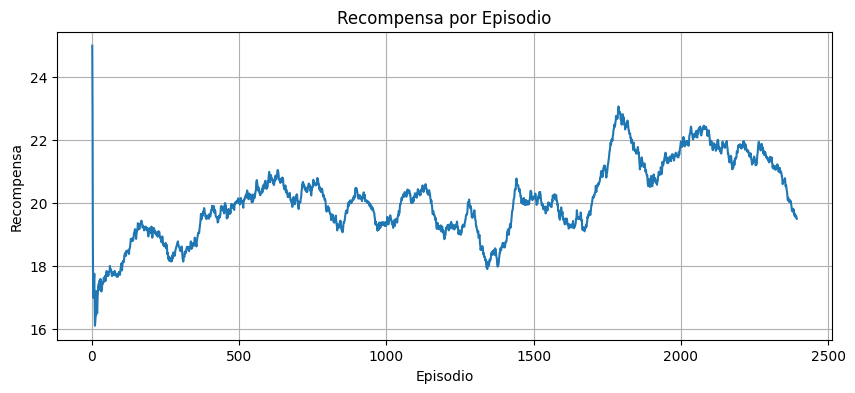

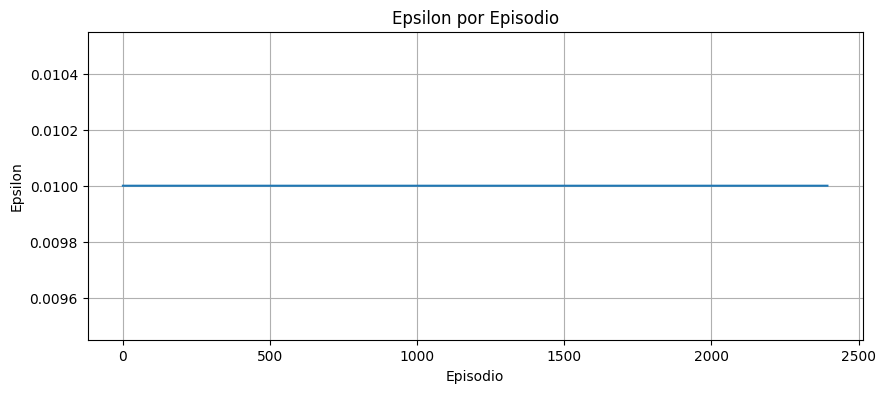

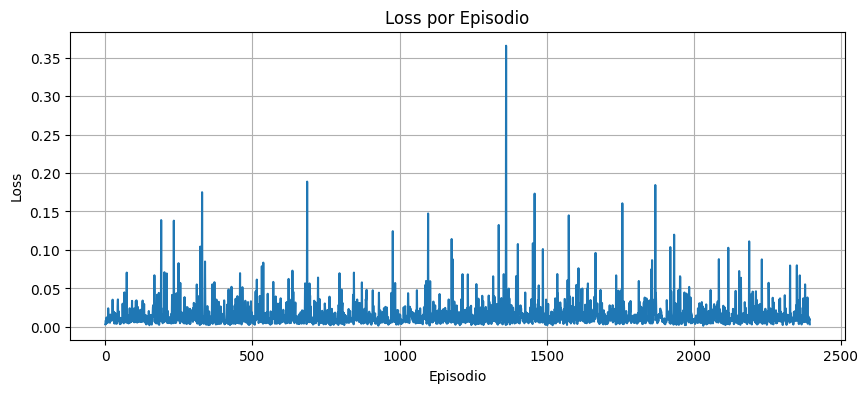

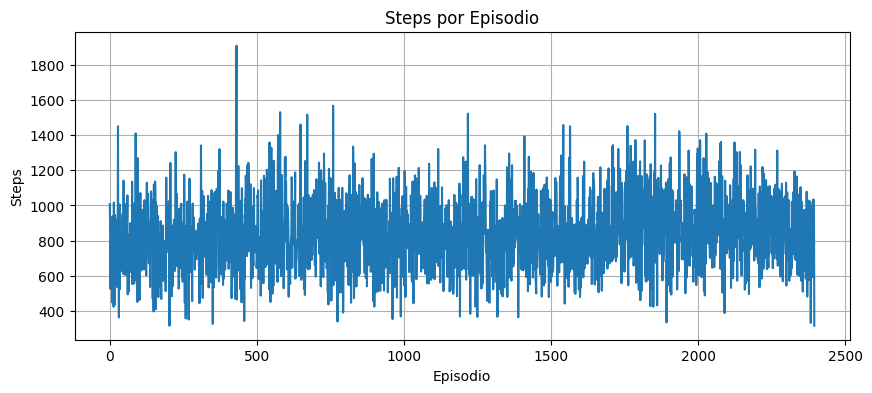

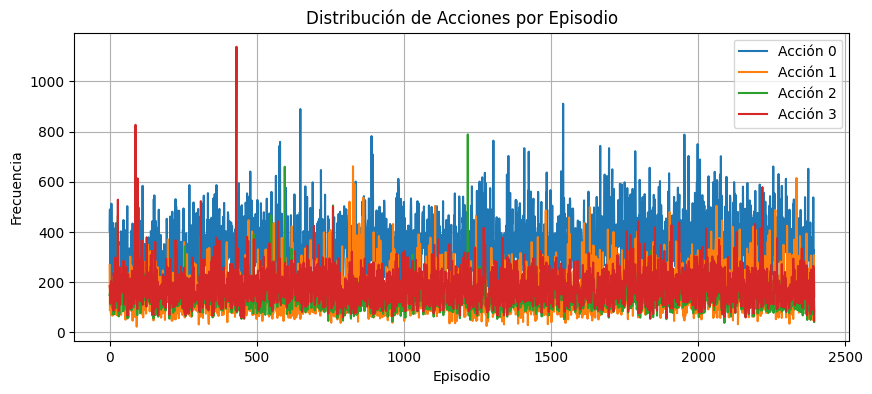

In [ ]:
METRICS_PATH  = getMetricFilePath(True, PHASE_4_3_ID)
graph_metrics(pathname=METRICS_PATH)

### Validation Phase 4

In [ ]:
dqn_agent = dqn_agent if 'dqn_agent' in locals() else None
video_path = execute_agent_play(dqn_agent, PHASE_4_3_ID)


./videos/dqn/validation/phase_4_3/breakout-episode-0.mp4
None


In [ ]:
Video(video_path, embed=True, width=600)

AQUI VA UNA CONCLUSION ARRECHA Y SUS GRAFICAS SI APLICA

# Double Deep Q Learning

Double DQN mejora la versión clásica de DQN corrigiendo el sesgo de sobreestimación de los valores
𝑄
Q. Para ello, desacopla la selección de la acción de su evaluación: en cada paso, la red online elige la acción que maximiza
𝑄
Q, pero la red objetivo distinta estima el valor de esa acción. Esta separación reduce el sesgo hacia valores demasiado optimistas y aporta mayor estabilidad al entrenamiento. El resto de la estructura —replay buffer, política ε-greedy, etc— se mantiene igual que en DQN, aprovechando así un diseño casi idéntico al original pero con resultados más fiables .

Fuente: [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)

> Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementación de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:
from double_dqn_agent import DoubleDQNAgent


def create_agent_with_load_net(phase_id, video_folder, load_net_path, episodes, total, gamma, epsilon_ini, epsilon_min, epsilon_anneal_steps):
    env = create_env(video_folder=video_folder)
    # Capturar los estados referentes p-ara visualizar la convergencia de los valores de Q
    modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
    if(load_net_path is not None):
        modelo_a.load_state_dict(torch.load(load_net_path))
    modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
    ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, gamma=gamma, epsilon_i= epsilon_ini, epsilon_f=epsilon_min, epsilon_anneal_steps=epsilon_anneal_steps, episode_block = EPISODE_BLOCK, device=DEVICE, run_name=phase_id)
    return ddqn_agent

# Entrenamiento Progresivo de un Agente DDQN en Breakout

En esta sección del obligatorio implementamos un agente basado en Double Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente cómo el agente mejora su rendimiento a través de fases de entrenamiento, visualización de métricas y evaluación.


## Preparación del entorno y del agente

Comenzamos creando el entorno y nuestro agente DDQN, basado en una red convolucional. Definimos los hiperparámetros iniciales que guiarán su comportamiento durante el entrenamiento.

Este paso es como presentar a nuestro protagonista antes de su viaje.

### Hiperparámetros fijos durante todo el entrenamiento


In [14]:
BATCH_SIZE = 32
BUFFER_SIZE = 50_000
EPISODE_BLOCK = 100
LEARNING_RATE = 1e-5
STEPS_PER_EPISODE = 20_000
GAMMA = 0.995

## 1. Primeros pasos de aprendizaje

En esta primera etapa del entrenamiento, el agente Double DQN inicia su interacción con el entorno, enfrentándose a situaciones desconocidas y acumulando experiencias variadas. Al igual que en el DQN, ejecutamos un bloque limitado a **100.000 pasos**, cuyo principal objetivo es permitir que el agente **explore de forma amplia** el espacio de estados y acciones.

Para lograr una exploración efectiva, utilizamos el mismo esquema de control epsilon que en el DQN:

- `EPSILON_INI = 1.0`: el agente inicia tomando acciones completamente aleatorias.
- `EPSILON_MIN = 0.3`: hacia el final del bloque, conserva todavía un 30% de probabilidad de explorar.

Este diseño sigue siendo clave porque el algoritmo Double DQN, al igual que el DQN, depende de la diversidad de experiencias almacenadas en el Replay Memory para estabilizar el aprendizaje futuro.

In [16]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_INITIAL)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

PHASE_ID: initial_run, TOTAL_STEPS: 100000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.3, EPSILON_ANNEAL_STEPS: 80000
Parametros del agente:
loadPath: None
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.3
epsilon_anneal_steps: 80000
run_name: initial_run


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento initial_run, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.3, epsilon_anneal_steps: 80000, max_steps: 100000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   5%|▍         | 491/10000 [08:19<2:41:07,  1.02s/episode, reward=1.72, epsilon=0.3, steps=1e+5]


Entrenamiento detenido: se alcanzaron 100001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


### Evaluar resultados del entrenamiento

Datos cargados de metrics/ddqn/metrics_initial_run.npz: [[60 42 63 41]
 [30 35 41 33]
 [51 58 54 42]
 ...
 [34 60 21 17]
 [38 38 48 12]
 [14 22 32 17]]


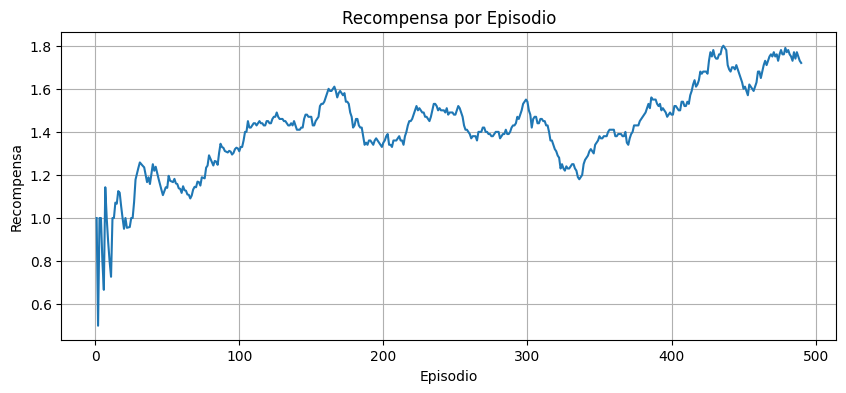

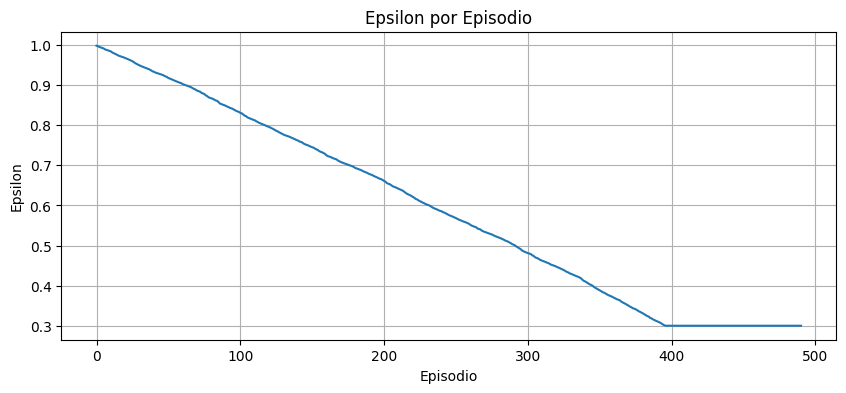

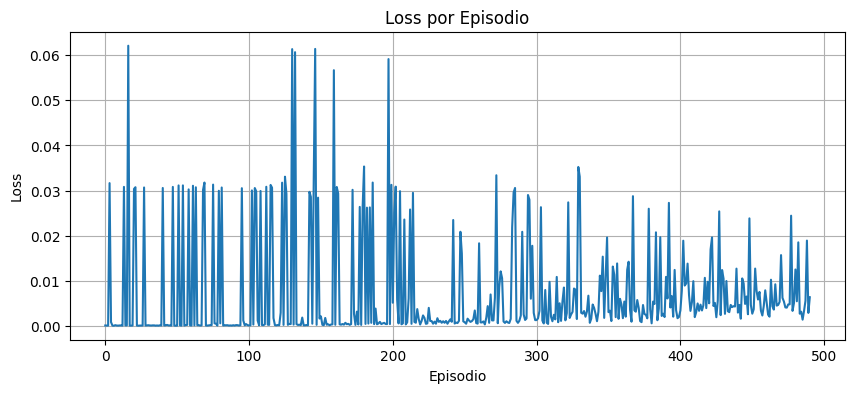

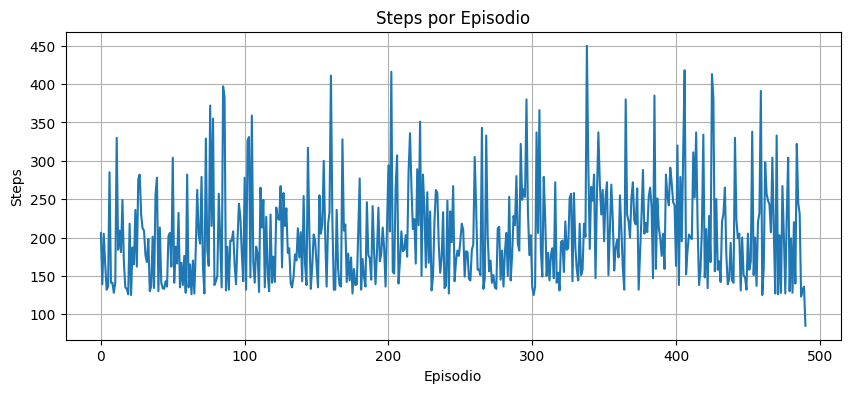

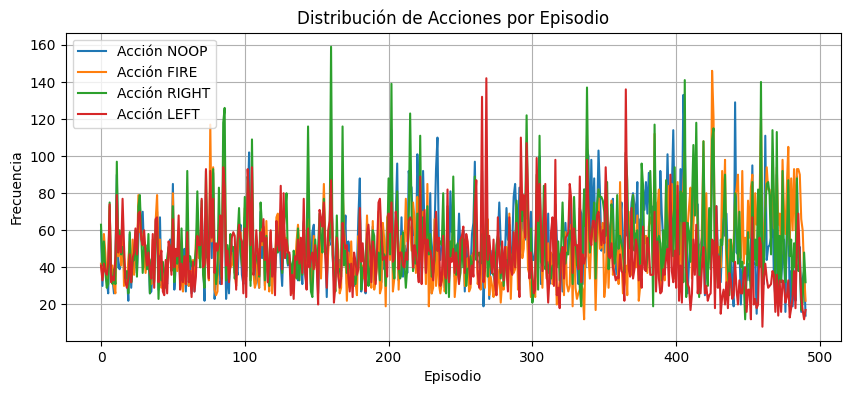

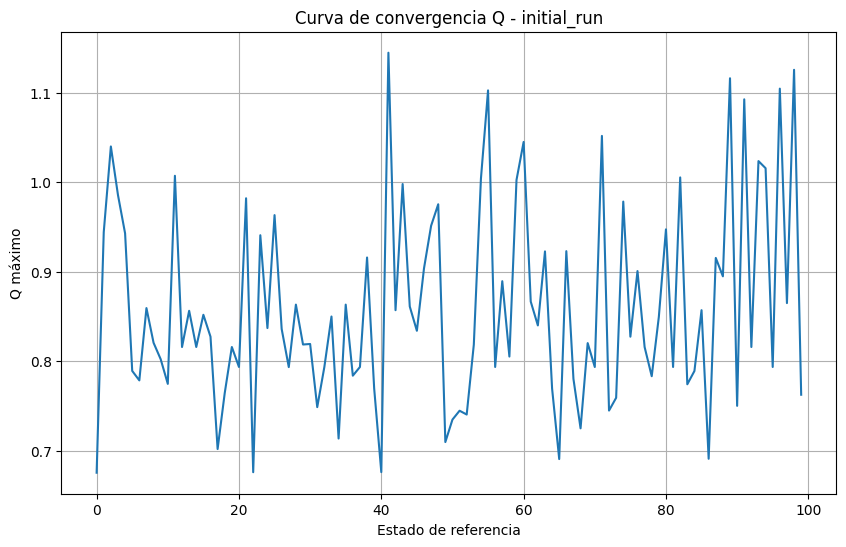

In [17]:
METRICS_PATH = getMetricFilePath(False, PHASE_INITIAL["id"])
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_INITIAL["id"], type=DOUBLE_DQN_TYPE)


### Evaluamos como juega el agente

In [23]:
video_path = execute_agent_play(ddqn_agent, PHASE_INITIAL["id"], DOUBLE_DQN_TYPE)
Video(video_path, embed=True, width=600)

Ejecutando el agente ddqn en modo evaluación...
Recompensa total del episodio 0: 0.0
Recompensa total promedio: 0.0


## 2. Fase 2 de entrenamiento: Aprendizaje básico

Después de la primera etapa de exploración, el enfoque en esta fase no es tanto seguir descubriendo, sino empezar a pulir. El agente ya tiene una idea básica de cómo funciona el entorno, por lo que ahora buscamos que sus decisiones sean menos impulsivas y más fundamentadas.

A diferencia del entrenamiento con DQN, donde a veces se tienden a sobre-valorar ciertas acciones, en esta etapa implementamos Double DQN. Esto mejora la estabilidad del aprendizaje al separar la acción que se elige de la acción que se evalúa, lo que reduce errores comunes al calcular los valores Q.

Para este bloque usamos **2.000.000 pasos** y ajustamos epsilon para que el agente aún explore, pero cada vez con más intención de explotar lo que ya aprendió. No se trata de tomar riesgos porque sí, sino de afinar su comportamiento usando la experiencia que va acumulando.

En este punto, ya no esperamos saltos grandes en la recompensa de un momento a otro. Más bien, buscamos señales de consistencia: que el agente repita buenos comportamientos, que sobreviva más tiempo y que el loss empiece a estabilizarse. La mejora puede parecer más lenta, pero es justamente el signo de que está aprendiendo de verdad.

- `EPSILON_INI = 1`
- `EPSILON_MIN = 0.1`
- `EPSILON_ANNEAL_STEPS = 1_500_000`

In [ ]:
EXPLORATION_GAMMA = 0.97
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_INITIAL_ID])
print(f"LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, gamma=EXPLORATION_GAMMA)

Datos cargados de metrics/ddqn/metrics_phase_2.npz: [[ 44  52  47  38]
 [ 43  48  39  44]
 [ 33  37  30  35]
 ...
 [127 199 118 188]
 [123 214 133 155]
 [ 95 135  96 105]]


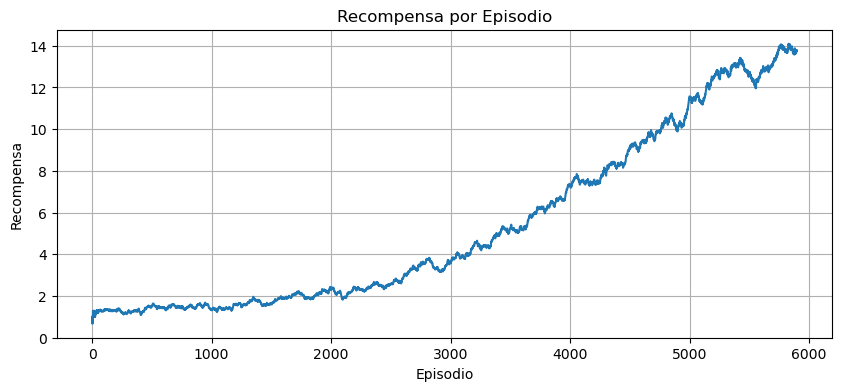

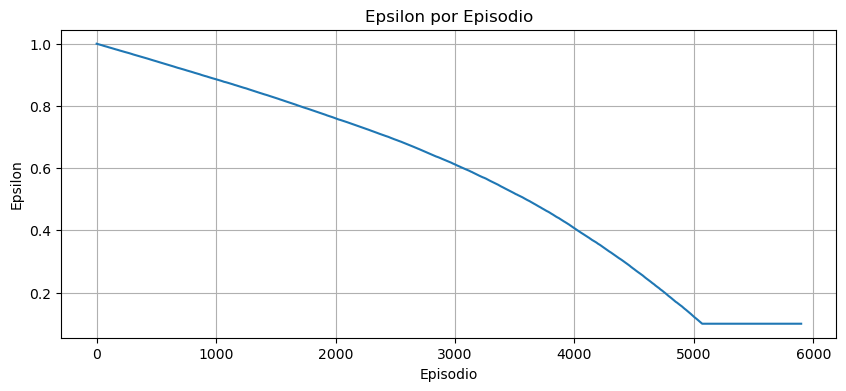

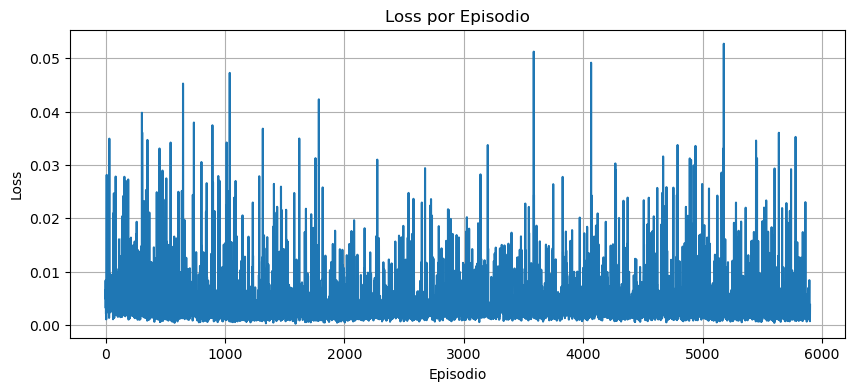

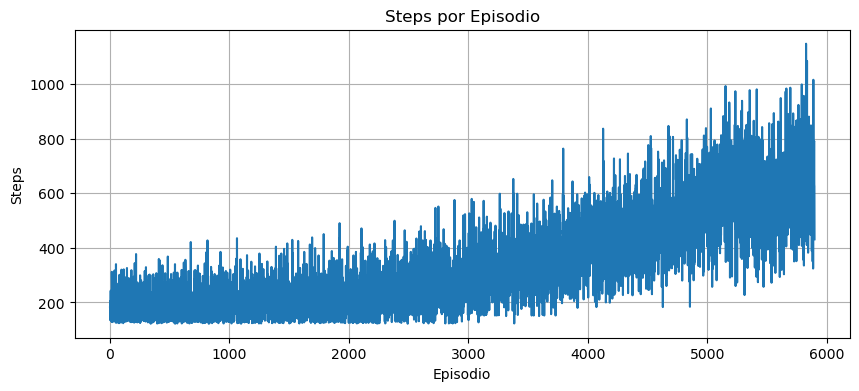

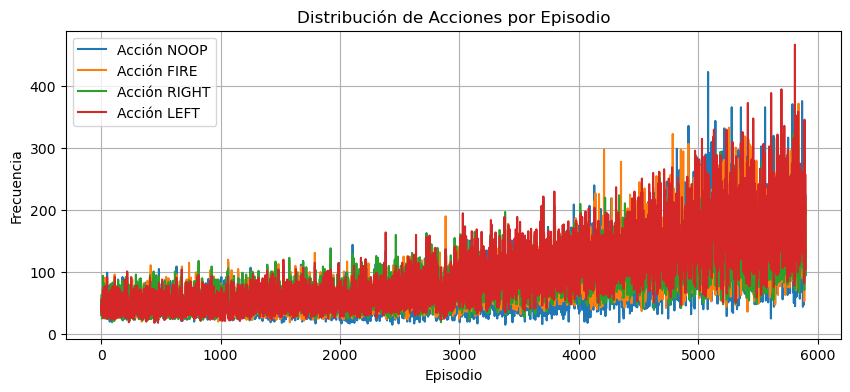

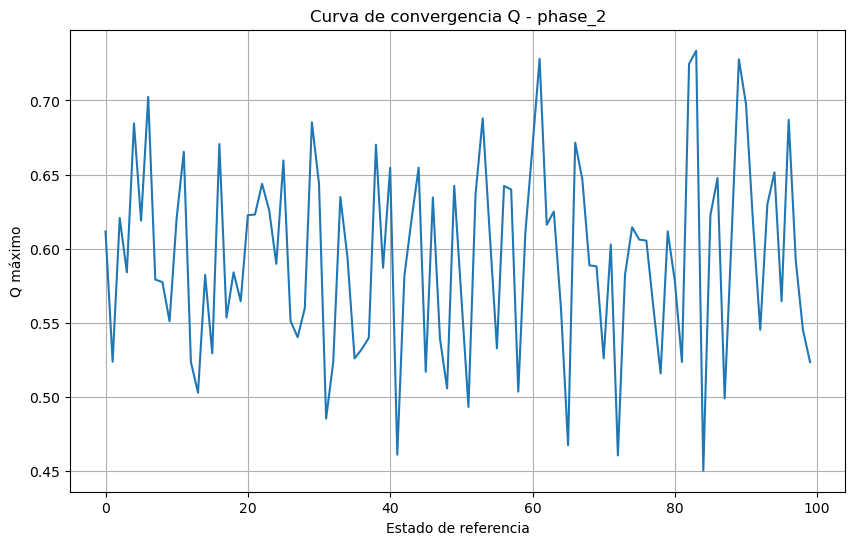

In [ ]:
METRICS_PATH = getMetricFilePath(False, PHASE_2["id"])
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_2["id"], type=DOUBLE_DQN_TYPE)

In [ ]:
video_path = execute_agent_play(ddqn_agent, PHASE_2["id"], DOUBLE_DQN_TYPE, play=False)
Video(video_path, embed=True, width=600)

## 3. Fase 3: Consolidación y estabilidad de la política

- `EPSILON_INI = 0.1`: partimos de una exploración baja, porque el agente ya tiene una base aprendida.
- `EPSILON_MIN = 0.01`: dejamos una pequeña ventana de exploración por si aún puede descubrir mejores acciones.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el `epsilon` decae lentamente, permitiendo una transición gradual hacia la explotación.

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_2["id"])
print(f"LOAD_NET_PATH: {LOAD_NET_PATH}")

PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = EPSILON_INI, epsilon_min = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_2.dat
PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/ddqn/GenericDDQNAgent-phase_2.dat
Parametros del agente:
loadPath: net_history/ddqn/GenericDDQNAgent-phase_2.dat
gamma: 0.995
epsilon_i: 0.1
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
run_name: phase_3


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.1, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   3%|▎         | 267/10000 [13:06<7:46:43,  2.88s/episode, reward=12.3, epsilon=0.0865, steps=150306]


=== Recompensa actual: 12.28, Epsilon: 0.08647246, Total steps: 150306 ===


Entrenando:   5%|▌         | 508/10000 [26:14<8:14:44,  3.13s/episode, reward=13.8, epsilon=0.073, steps=3e+5]


=== Recompensa actual: 13.8, Epsilon: 0.07297615, Total steps: 300265 ===


Entrenando:   7%|▋         | 749/10000 [39:16<9:20:23,  3.63s/episode, reward=13.3, epsilon=0.0594, steps=450684]


=== Recompensa actual: 13.26, Epsilon: 0.05943844, Total steps: 450684 ===


Entrenando:  10%|▉         | 980/10000 [52:18<10:03:16,  4.01s/episode, reward=15.6, epsilon=0.0459, steps=600635]


=== Recompensa actual: 15.58, Epsilon: 0.04594284999999999, Total steps: 600635 ===


Entrenando:  12%|█▏        | 1189/10000 [1:05:20<9:30:03,  3.88s/episode, reward=16.8, epsilon=0.0325, steps=750347]


=== Recompensa actual: 16.76, Epsilon: 0.032468769999999994, Total steps: 750347 ===


Entrenando:  14%|█▍        | 1381/10000 [1:18:20<9:55:39,  4.15s/episode, reward=17.9, epsilon=0.019, steps=9e+5]


=== Recompensa actual: 17.92, Epsilon: 0.018984699999999993, Total steps: 900170 ===


Entrenando:  16%|█▌        | 1573/10000 [1:31:29<10:10:30,  4.35s/episode, reward=18.4, epsilon=0.01, steps=1050569]


=== Recompensa actual: 18.38, Epsilon: 0.01, Total steps: 1050569 ===


Entrenando:  18%|█▊        | 1762/10000 [1:44:26<9:18:13,  4.07s/episode, reward=18.6, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 18.64, Epsilon: 0.01, Total steps: 1200378 ===


Entrenando:  19%|█▉        | 1943/10000 [1:57:23<10:03:07,  4.49s/episode, reward=20.7, epsilon=0.01, steps=1350658]


=== Recompensa actual: 20.66, Epsilon: 0.01, Total steps: 1350658 ===


Entrenando:  21%|██        | 2120/10000 [2:10:24<9:32:38,  4.36s/episode, reward=20.4, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 20.36, Epsilon: 0.01, Total steps: 1500159 ===


Entrenando:  23%|██▎       | 2296/10000 [2:23:19<9:04:57,  4.24s/episode, reward=20, epsilon=0.01, steps=1650688]


=== Recompensa actual: 20.0, Epsilon: 0.01, Total steps: 1650688 ===


Entrenando:  25%|██▍       | 2463/10000 [2:36:07<11:36:16,  5.54s/episode, reward=22.8, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 22.77, Epsilon: 0.01, Total steps: 1800387 ===


Entrenando:  26%|██▌       | 2624/10000 [2:49:03<10:23:19,  5.07s/episode, reward=23.3, epsilon=0.01, steps=1950694]


=== Recompensa actual: 23.33, Epsilon: 0.01, Total steps: 1950694 ===


Entrenando:  27%|██▋       | 2680/10000 [2:53:17<7:53:18,  3.88s/episode, reward=22, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


Datos cargados de metrics/ddqn/metrics_phase_3.npz: [[ 28 144 140 164]
 [198 149 192 223]
 [101  96 129 128]
 ...
 [368 230 227 234]
 [110 377 181 182]
 [236 176 173 212]]


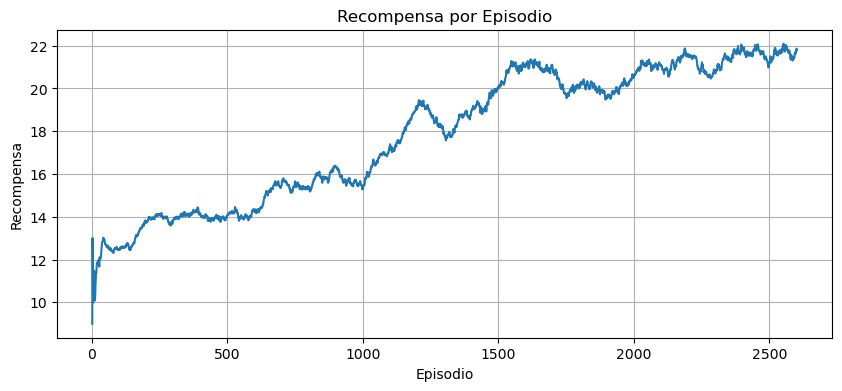

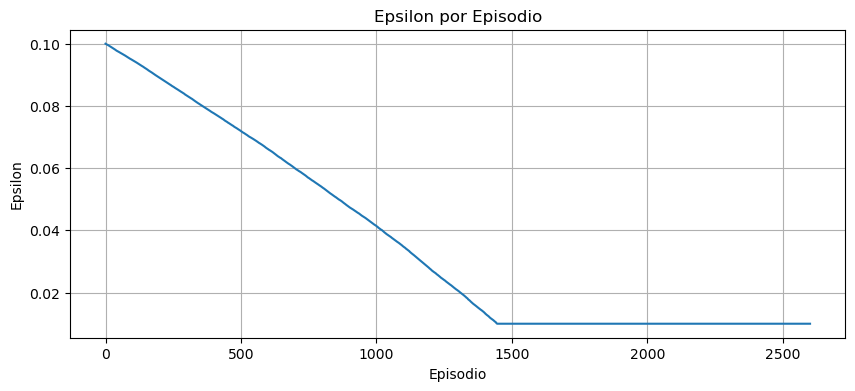

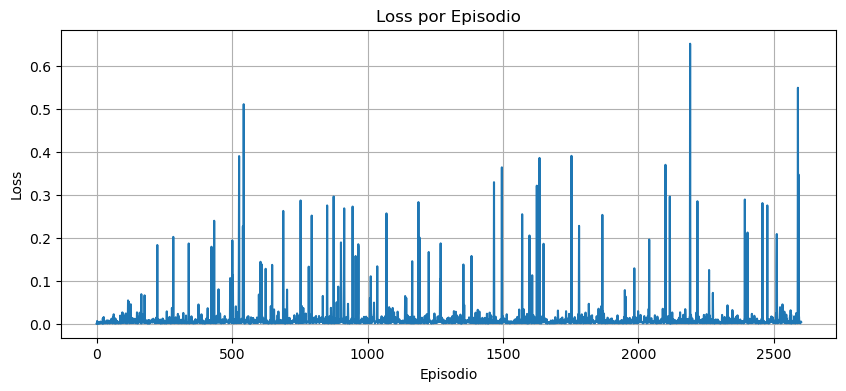

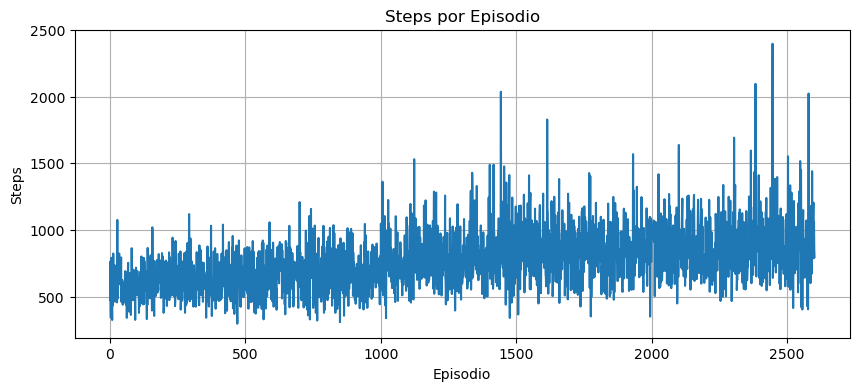

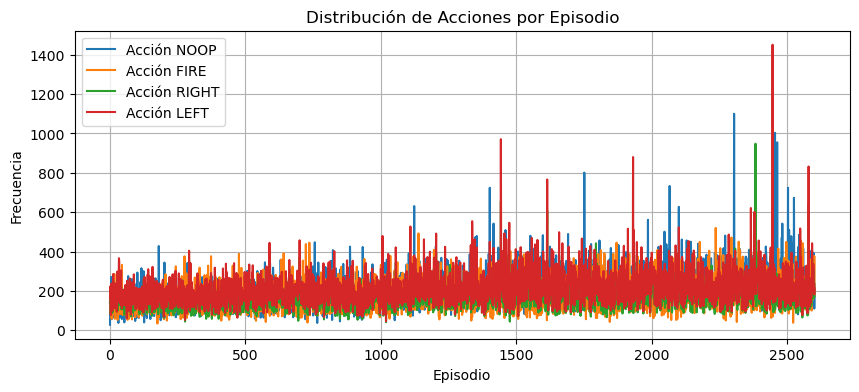

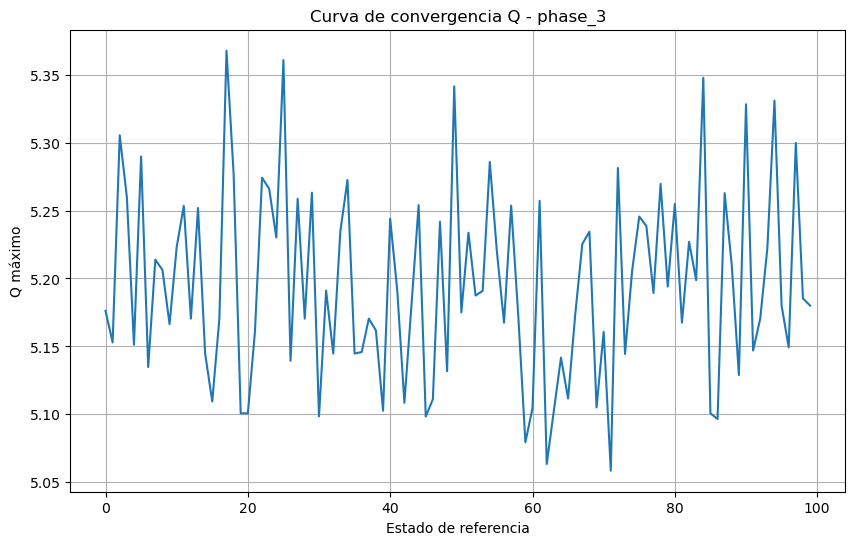

In [ ]:
METRICS_PATH = getMetricFilePath(False, PHASE_3["id"])
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_3["id"], type=DOUBLE_DQN_TYPE)

In [ ]:
video_path = execute_agent_play(ddqn_agent, PHASE_ID, DOUBLE_DQN_TYPE, play=False)
Video(video_path, embed=True, width=600)

## 5. Entrenamiento largo

Se van a ejecutar **7.000.000** de pasos dividos en 1 fase de **1.000.000.** de pasos y 3 fases una de **2.000.000** de pasos

Mantenemos un valor inicial muy bajo para promover una política estable, pero sin eliminar por completo la posibilidad de explorar si se presenta algo poco frecuente:

- `EPSILON_INI = 0.05`: el agente comienza confiando casi por completo en su política aprendida.
- `EPSILON_MIN = 0.01`: se conserva un margen muy pequeño de exploración para evitar caer en políticas rígidas o locales.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el descenso es lento y progresivo, asegurando una transición estable hacia la explotación total.


In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4)
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_3_ID)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
VIDEO_FOLDER = f"./videos/dqn_training_{PHASE_ID}"


In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_4_1["id"])
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = 0.05, epsilon_min = 0.05, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS)

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(False, PHASE_4_2["id"])
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
ddqn_agent = execute_ddqn_training_phase(PHASE_ID, reference_states, load_net_path=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_ini = 0.1, epsilon_min = 0.05, epsilon_anneal_steps = 500_000, learning_rate=2e-5)

In [ ]:
execute_ddqn_training_phase(
    PHASE_ID,
    total_steps=TOTAL_STEPS,
    episodes=EPISODES,
    epsilon_ini=EPSILON_INI,
    epsilon_min=EPSILON_MIN,
    epsilon_anneal_steps=EPSILON_ANNEAL_STEPS,
    load_net_path=LOAD_NET_PATH
)

In [ ]:
metrics_path = getMetricFilePath(False, PHASE_ID)
evaluate_training_phase_results(metrics_path, PHASE_ID)

In [ ]:
execute_ddqn_training_phase("phase_4_1", total_steps=1_000_000, episodes=EPISODES, epsilon_ini=0.01, epsilon_min=0.01, epsilon_anneal_steps=1_000_000, load_net_path="net_history/ddqn/GenericDDQNAgent-run:phase_4_1_final.dat", play=True)

### Entrenamos

In [ ]:
from double_dqn_agent import DoubleDQNAgent

env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )


modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block = EPISODE_BLOCK, device=DEVICE)

ddqn_rewards = ddqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

ddqn_agent.play(env, episodes=3)

env.close()

In [ ]:
# Ruta al archivo de vídeo en tu sistema de ficheros
video_path = "./videos/ddqn_validation/breakout-episode-0.mp4"

# Muestra el vídeo
Video(video_path, embed=True, width=600)

#### Graficas
...

# Experimentación
Aquí con libertad total, pueden probar diferentes arquitecturas de red, diferentes hiperparámetros, diferentes técnicas de exploración, etc.
...

In [ ]:
def getReplayMemoryPhaseId(phase_id):
    return f"rm_{phase_id}"

In [ ]:
'''
PHASE_ID = "phase_3"
PREV_PHASE_ID = getReplayMemoryPhaseId(PHASE_3_ID)
LOAD_NET_PATH = getGenericDataFilePath(True, PREV_PHASE_ID)
print(f"net a cargar con PHASE_ID: {PREV_PHASE_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, use_prioritized_replay=True)
'''

'\nPHASE_ID = "phase_3"\nPREV_PHASE_ID = PHASE_3["id"]\nLOAD_NET_PATH = getGenericDataFilePath(True, PREV_PHASE_ID)\nprint(f"net a cargar con PHASE_ID: {PHASE_ID}")\nPHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)\nprint(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")\ndqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, loadPath=LOAD_NET_PATH, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, use_prioritized_replay=True)\n'

In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_INITIAL)
PHASE_ID = getReplayMemoryPhaseId(PHASE_INITIAL_ID)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")

PHASE_ID: initial_run, TOTAL_STEPS: 100000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.3, EPSILON_ANNEAL_STEPS: 80000


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, use_prioritized_replay=True)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.3
epsilon_anneal_steps: 80000
episode_block: 100
run_name: initial_run
Use prioritized memory: True


c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\OBL solo octa\obligatorio-taller-ia\videos\dqn\initial_run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento initial_run, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.3, epsilon_anneal_steps: 80000, max_steps: 100000




c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   5%|▌         | 518/10000 [14:49<4:31:24,  1.72s/episode, reward=1.33, epsilon=0.3, steps=1e+5]   


Entrenamiento detenido: se alcanzaron 100001 pasos.



c:\Users\Octav\postgrado\taller ia\OBL solo octa\obligatorio-taller-ia\load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
PHASE_ID = getReplayMemoryPhaseId(PHASE_INITIAL_ID)
video_path = execute_agent_play(dqn_agent, PHASE_ID)
Video(video_path, embed=True, width=600)

c:\Users\Octav\anaconda3\envs\obl_taller_ia\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\Octav\postgrado\taller ia\OBL solo octa\obligatorio-taller-ia\videos\dqn\validation\initial_run folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recompensa total del episodio 0: 0.0
Recompensa total promedio: 0.0


Datos cargados de metrics/dqn/metrics_initial_run.npz: [[47 30 31 35]
 [36 34 28 33]
 [38 49 45 42]
 ...
 [ 9 45 46 26]
 [50 31 33 19]
 [24 46 26 22]]


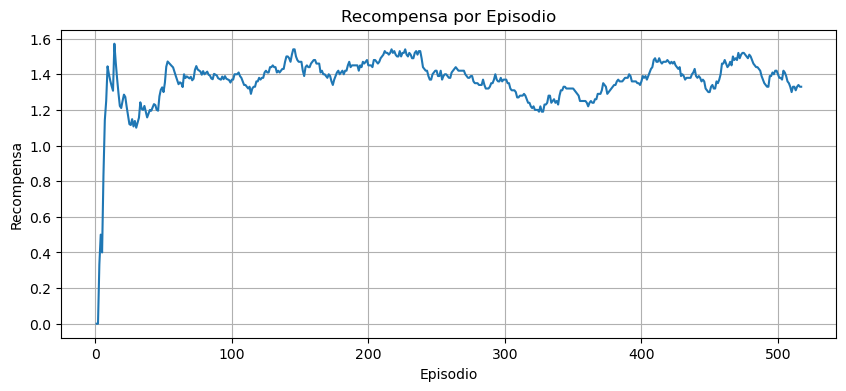

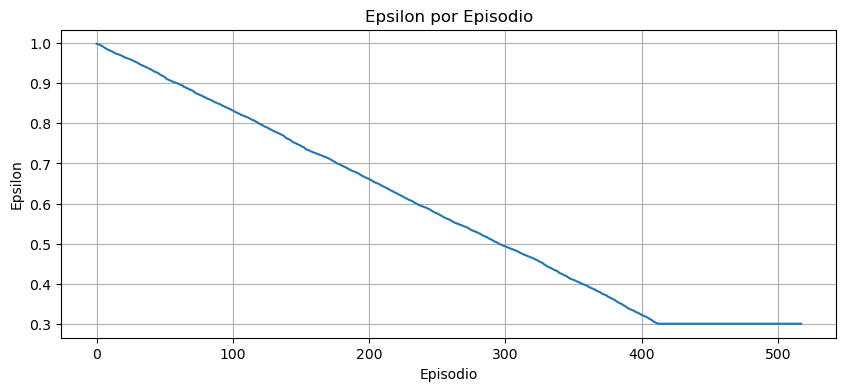

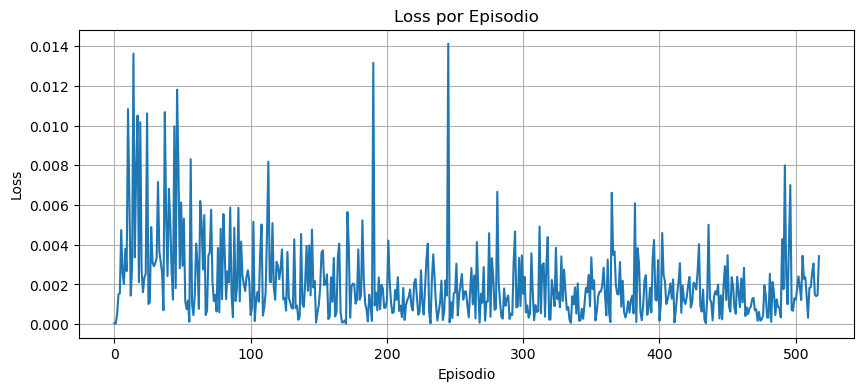

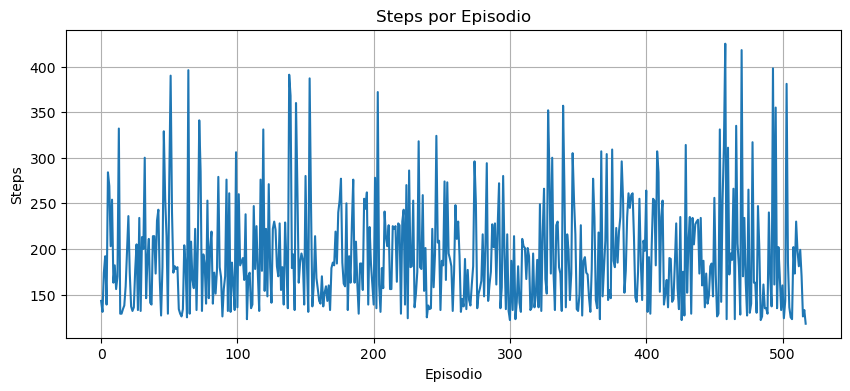

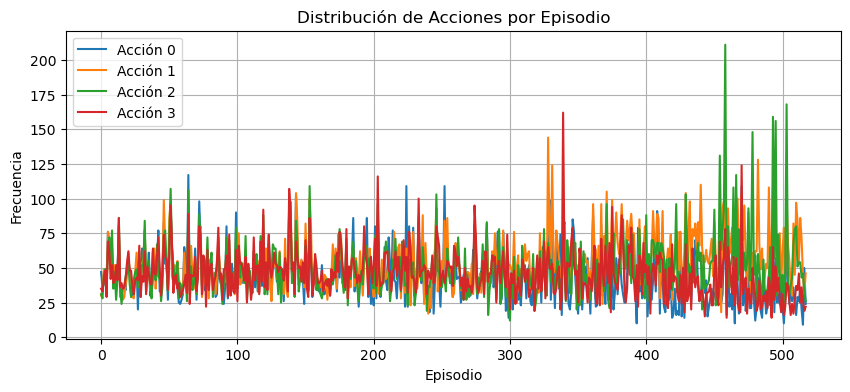

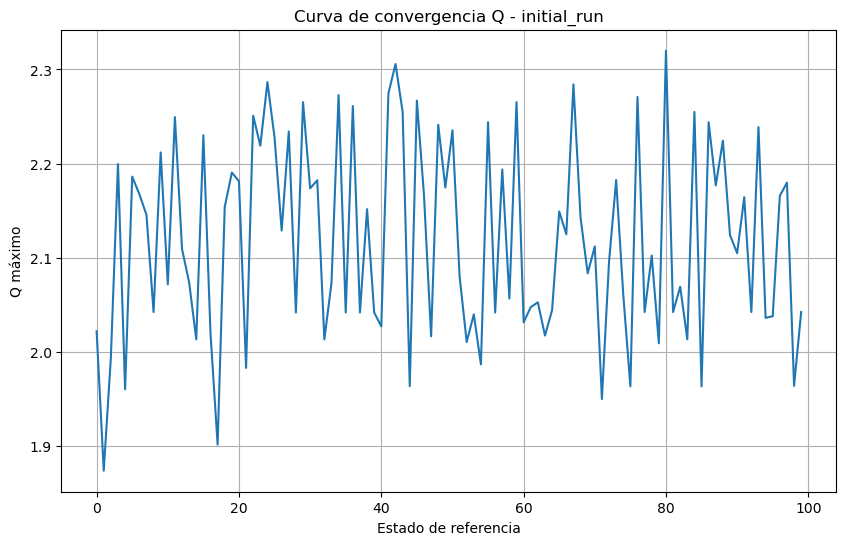

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_ID)

In [ ]:
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_2)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}")

PHASE_ID: phase_2, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 1, EPSILON_MIN: 0.1, EPSILON_ANNEAL_STEPS: 1500000


In [ ]:
dqn_agent = execute_dqn_training_phase(PHASE_ID, reference_states, total_steps = TOTAL_STEPS, episodes = EPISODES, epsilon_i = EPSILON_INI, epsilon_f = EPSILON_MIN, epsilon_anneal_steps = EPSILON_ANNEAL_STEPS, use_prioritized_replay=True)

Parametros del agente:
loadPath: None
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 1
epsilon_f: 0.1
epsilon_anneal_steps: 1500000
episode_block: 100
run_name: phase_2
Use prioritized memory: True


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_2, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 1, epsilon_f: 0.1, epsilon_anneal_steps: 1500000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   8%|▊         | 803/10000 [14:00<2:23:57,  1.06episode/s, reward=1.05, epsilon=0.91, steps=150116]


=== Recompensa actual: 1.05, Epsilon: 0.9099304, Total steps: 150116 ===


Entrenando:  16%|█▌        | 1581/10000 [28:06<3:04:24,  1.31s/episode, reward=1.64, epsilon=0.82, steps=3e+5]


=== Recompensa actual: 1.64, Epsilon: 0.8199466, Total steps: 300089 ===


Entrenando:  23%|██▎       | 2332/10000 [42:02<2:27:54,  1.16s/episode, reward=2.12, epsilon=0.73, steps=450136]


=== Recompensa actual: 2.12, Epsilon: 0.7299184, Total steps: 450136 ===


Entrenando:  30%|███       | 3021/10000 [55:52<2:32:51,  1.31s/episode, reward=2.26, epsilon=0.64, steps=6e+5]


=== Recompensa actual: 2.26, Epsilon: 0.639937, Total steps: 600105 ===


Entrenando:  37%|███▋      | 3695/10000 [1:10:02<2:12:36,  1.26s/episode, reward=2.53, epsilon=0.55, steps=750084]


=== Recompensa actual: 2.53, Epsilon: 0.5499496, Total steps: 750084 ===


Entrenando:  43%|████▎     | 4307/10000 [1:24:37<2:31:56,  1.60s/episode, reward=2.79, epsilon=0.46, steps=9e+5]


=== Recompensa actual: 2.79, Epsilon: 0.4599622, Total steps: 900063 ===


Entrenando:  49%|████▉     | 4936/10000 [1:38:47<2:46:33,  1.97s/episode, reward=2.98, epsilon=0.37, steps=1050047]


=== Recompensa actual: 2.98, Epsilon: 0.36997179999999996, Total steps: 1050047 ===


Entrenando:  54%|█████▍    | 5444/10000 [1:52:51<1:47:30,  1.42s/episode, reward=4.74, epsilon=0.28, steps=1.2e+6]


=== Recompensa actual: 4.74, Epsilon: 0.27993579999999996, Total steps: 1200107 ===


Entrenando:  59%|█████▉    | 5903/10000 [2:07:16<1:50:47,  1.62s/episode, reward=5.39, epsilon=0.19, steps=1350240]


=== Recompensa actual: 5.39, Epsilon: 0.18985600000000002, Total steps: 1350240 ===


Entrenando:  63%|██████▎   | 6286/10000 [2:21:55<2:06:33,  2.04s/episode, reward=7.5, epsilon=0.1, steps=1.5e+6]


=== Recompensa actual: 7.5, Epsilon: 0.1, Total steps: 1500126 ===


Entrenando:  66%|██████▌   | 6621/10000 [2:36:22<2:27:28,  2.62s/episode, reward=8.78, epsilon=0.1, steps=1650376]


=== Recompensa actual: 8.78, Epsilon: 0.1, Total steps: 1650376 ===


Entrenando:  69%|██████▉   | 6927/10000 [2:51:02<3:01:20,  3.54s/episode, reward=9.93, epsilon=0.1, steps=1.8e+6]


=== Recompensa actual: 9.93, Epsilon: 0.1, Total steps: 1800595 ===


Entrenando:  72%|███████▏  | 7219/10000 [3:05:34<2:33:05,  3.30s/episode, reward=10.5, epsilon=0.1, steps=1950376]


=== Recompensa actual: 10.54, Epsilon: 0.1, Total steps: 1950376 ===


Entrenando:  73%|███████▎  | 7310/10000 [3:10:23<1:10:03,  1.56s/episode, reward=11.1, epsilon=0.1, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_ID)
Video(video_path, embed=True, width=600)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/obligatorio-taller-ia/videos/dqn/validation/phase_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recompensa total del episodio 0: 10.0
Recompensa total promedio: 10.0


Datos cargados de metrics/dqn/metrics_phase_2.npz: [[ 31  39  40  33]
 [ 44  56  56  50]
 [ 60  48  59  53]
 ...
 [ 89 162 250 304]
 [109 113 151 193]
 [ 74  38  68  88]]


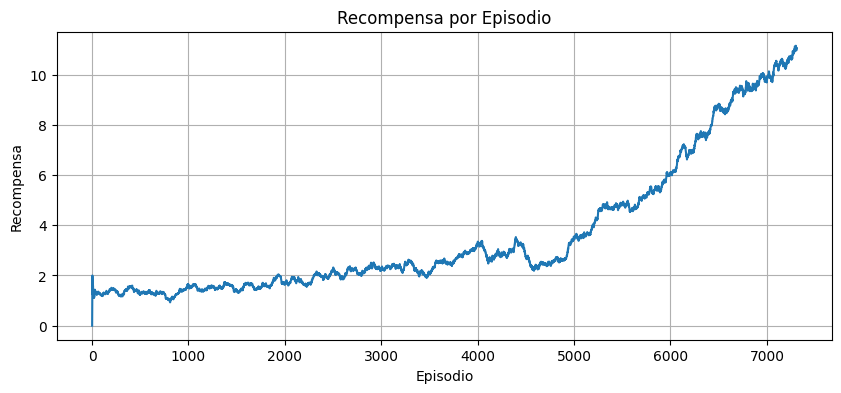

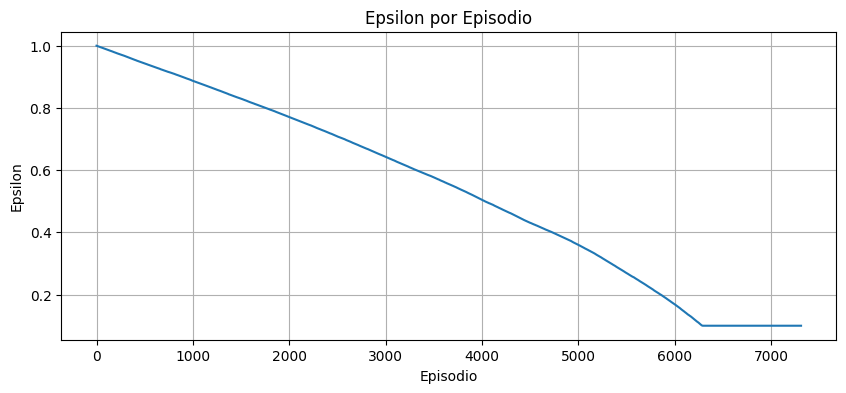

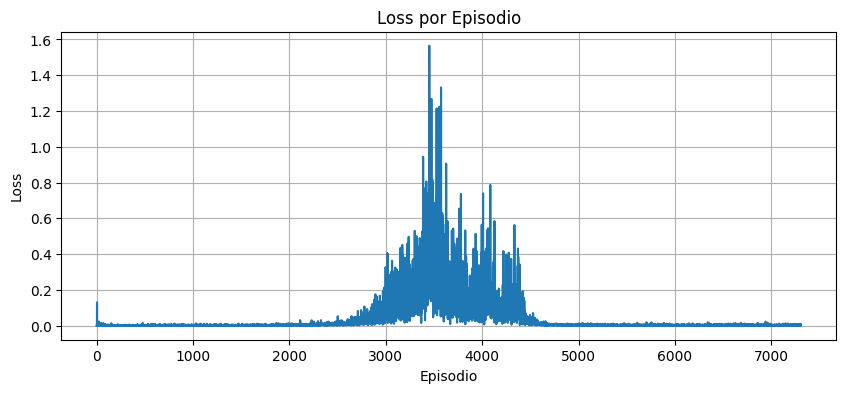

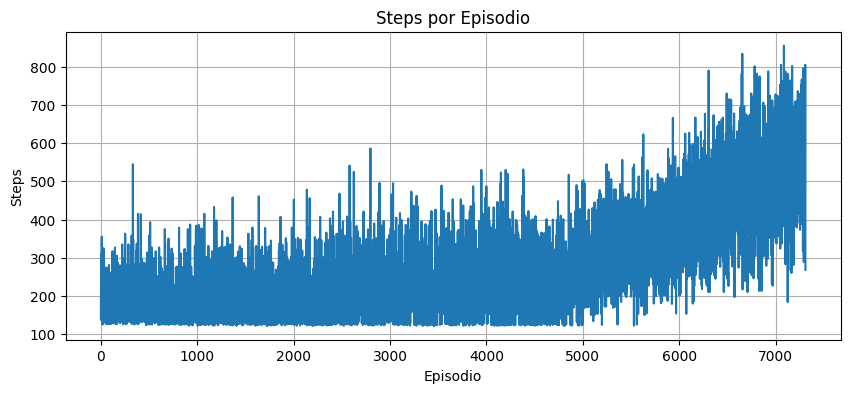

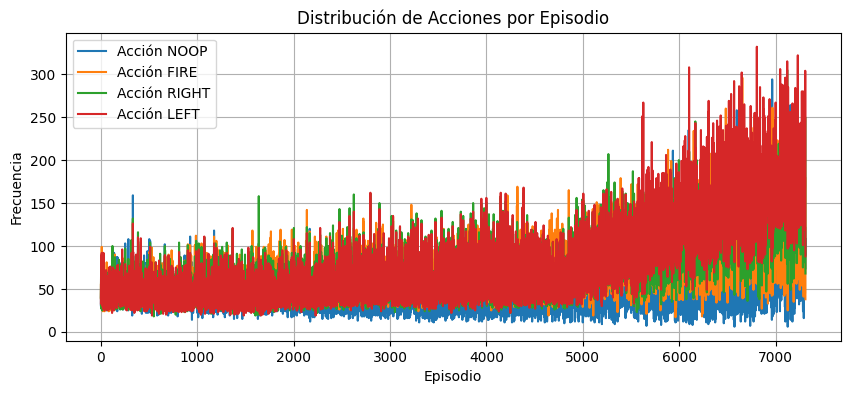

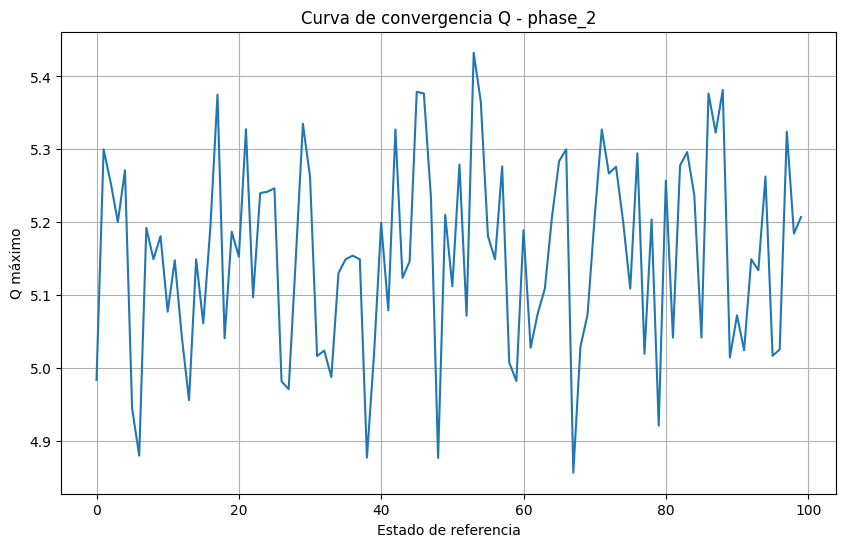

In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_ID)

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_2_ID)
print(f"net a cargar con PHASE_ID: {PHASE_2_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_3)
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_2
PHASE_ID: phase_3, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.1, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_2.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
    PHASE_ID,
    reference_states,
    loadPath=LOAD_NET_PATH,
    total_steps = TOTAL_STEPS,
    episodes = EPISODES,
    epsilon_i = EPSILON_INI,
    epsilon_f = EPSILON_MIN,
    epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
    use_prioritized_replay=True
  )

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_2.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.1
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: phase_3
Use prioritized memory: True


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento phase_3, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.1, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   3%|▎         | 278/10000 [15:14<9:23:36,  3.48s/episode, reward=11.6, epsilon=0.0865, steps=150077]


=== Recompensa actual: 11.58, Epsilon: 0.08649307, Total steps: 150077 ===


Entrenando:   5%|▌         | 546/10000 [29:41<8:28:52,  3.23s/episode, reward=11.7, epsilon=0.073, steps=3e+5]


=== Recompensa actual: 11.71, Epsilon: 0.07295698, Total steps: 300478 ===


Entrenando:   8%|▊         | 798/10000 [44:33<8:45:54,  3.43s/episode, reward=12.2, epsilon=0.0595, steps=450507]


=== Recompensa actual: 12.22, Epsilon: 0.05945437, Total steps: 450507 ===


Entrenando:  11%|█         | 1056/10000 [59:24<9:41:56,  3.90s/episode, reward=13, epsilon=0.046, steps=600512]


=== Recompensa actual: 13.01, Epsilon: 0.045953919999999995, Total steps: 600512 ===


Entrenando:  13%|█▎        | 1295/10000 [1:14:19<7:51:29,  3.25s/episode, reward=14.4, epsilon=0.0325, steps=750260]


=== Recompensa actual: 14.44, Epsilon: 0.032476599999999994, Total steps: 750260 ===


Entrenando:  15%|█▌        | 1522/10000 [1:29:13<9:26:15,  4.01s/episode, reward=15, epsilon=0.019, steps=9e+5]


=== Recompensa actual: 15.04, Epsilon: 0.018970749999999995, Total steps: 900325 ===


Entrenando:  17%|█▋        | 1745/10000 [1:44:07<8:45:22,  3.82s/episode, reward=14.3, epsilon=0.01, steps=1050096]


=== Recompensa actual: 14.27, Epsilon: 0.01, Total steps: 1050096 ===


Entrenando:  20%|█▉        | 1961/10000 [1:59:07<11:17:13,  5.05s/episode, reward=16, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 16.0, Epsilon: 0.01, Total steps: 1200517 ===


Entrenando:  22%|██▏       | 2166/10000 [2:13:20<7:25:36,  3.41s/episode, reward=17.2, epsilon=0.01, steps=1350099]


=== Recompensa actual: 17.19, Epsilon: 0.01, Total steps: 1350099 ===


Entrenando:  24%|██▍       | 2375/10000 [2:27:48<9:08:47,  4.32s/episode, reward=15.9, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 15.86, Epsilon: 0.01, Total steps: 1500117 ===


Entrenando:  26%|██▌       | 2579/10000 [2:42:19<8:58:52,  4.36s/episode, reward=16.7, epsilon=0.01, steps=1650109]


=== Recompensa actual: 16.67, Epsilon: 0.01, Total steps: 1650109 ===


Entrenando:  28%|██▊       | 2781/10000 [2:57:30<9:12:48,  4.59s/episode, reward=17.1, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 17.09, Epsilon: 0.01, Total steps: 1800557 ===


Entrenando:  30%|██▉       | 2987/10000 [3:12:07<10:00:19,  5.14s/episode, reward=16.9, epsilon=0.01, steps=1950128]


=== Recompensa actual: 16.89, Epsilon: 0.01, Total steps: 1950128 ===


Entrenando:  31%|███       | 3054/10000 [3:17:09<7:28:25,  3.87s/episode, reward=17.4, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


In [ ]:
video_path = execute_agent_play(dqn_agent, PHASE_ID)
Video(video_path, embed=True, width=600)

Recompensa total del episodio 0: 19.0
Recompensa total promedio: 19.0


In [ ]:
METRICS_PATH = getMetricFilePath(True, PHASE_ID)
evaluate_training_phase_results(pathname=METRICS_PATH, phase_id=PHASE_ID)

In [ ]:
LOAD_NET_PATH = getGenericDataFilePath(True, PHASE_3_ID)
print(f"net a cargar con PHASE_ID: {PHASE_3_ID}")
PHASE_ID, TOTAL_STEPS, EPISODES, EPSILON_INI, EPSILON_MIN, EPSILON_ANNEAL_STEPS = get_phase_attributes(PHASE_4_1)
PHASE_ID = f"rm_{PHASE_ID}"
print(f"PHASE_ID: {PHASE_ID}, TOTAL_STEPS: {TOTAL_STEPS}, EPISODES: {EPISODES}, EPSILON_INI: {EPSILON_INI}, EPSILON_MIN: {EPSILON_MIN}, EPSILON_ANNEAL_STEPS: {EPSILON_ANNEAL_STEPS}, LOAD_NET_PATH: {LOAD_NET_PATH}")

net a cargar con PHASE_ID: phase_3
PHASE_ID: rm_phase_4_1, TOTAL_STEPS: 2000000, EPISODES: 10000, EPSILON_INI: 0.05, EPSILON_MIN: 0.01, EPSILON_ANNEAL_STEPS: 1000000, LOAD_NET_PATH: net_history/dqn/GenericDQNAgent-phase_3.dat


In [ ]:
dqn_agent = execute_dqn_training_phase(
    PHASE_ID,
    reference_states,
    loadPath=LOAD_NET_PATH,
    total_steps = TOTAL_STEPS,
    episodes = EPISODES,
    epsilon_i = EPSILON_INI,
    epsilon_f = EPSILON_MIN,
    epsilon_anneal_steps = EPSILON_ANNEAL_STEPS,
    use_prioritized_replay=True
  )

Parametros del agente:
loadPath: net_history/dqn/GenericDQNAgent-phase_3.dat
buffer_size: 50000
batch_size: 32
learning_rate: 1e-05
gamma: 0.995
epsilon_i: 0.05
epsilon_f: 0.01
epsilon_anneal_steps: 1000000
episode_block: 100
run_name: rm_phase_4_1
Use prioritized memory: True


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]



Iniciando entrenamiento rm_phase_4_1, con los siguientes hiperparametros:

gamma: 0.995, epsilon_i: 0.05, epsilon_f: 0.01, epsilon_anneal_steps: 1000000, max_steps: 2000000




/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   2%|▏         | 222/10000 [14:28<9:28:59,  3.49s/episode, reward=15.3, epsilon=0.044, steps=150325]


=== Recompensa actual: 15.33, Epsilon: 0.043987000000000005, Total steps: 150325 ===


Entrenando:   4%|▍         | 429/10000 [28:35<12:43:37,  4.79s/episode, reward=17.1, epsilon=0.038, steps=3e+5]


=== Recompensa actual: 17.12, Epsilon: 0.037993280000000004, Total steps: 300168 ===


Entrenando:   6%|▋         | 634/10000 [42:48<8:55:31,  3.43s/episode, reward=17, epsilon=0.032, steps=450208]


=== Recompensa actual: 16.98, Epsilon: 0.03199168, Total steps: 450208 ===


Entrenando:   8%|▊         | 838/10000 [56:52<12:37:05,  4.96s/episode, reward=16.7, epsilon=0.026, steps=6e+5]


=== Recompensa actual: 16.69, Epsilon: 0.025980640000000003, Total steps: 600484 ===


Entrenando:  10%|█         | 1031/10000 [1:11:03<10:45:12,  4.32s/episode, reward=18.2, epsilon=0.02, steps=750723]


=== Recompensa actual: 18.25, Epsilon: 0.019971080000000002, Total steps: 750723 ===


Entrenando:  12%|█▏        | 1221/10000 [1:25:26<10:59:20,  4.51s/episode, reward=18.9, epsilon=0.014, steps=9e+5]


=== Recompensa actual: 18.92, Epsilon: 0.013994239999999998, Total steps: 900144 ===


Entrenando:  14%|█▍        | 1411/10000 [1:40:00<11:22:33,  4.77s/episode, reward=18.2, epsilon=0.01, steps=1050287]


=== Recompensa actual: 18.19, Epsilon: 0.01, Total steps: 1050287 ===


Entrenando:  16%|█▌        | 1597/10000 [1:54:18<11:07:00,  4.76s/episode, reward=18.8, epsilon=0.01, steps=1.2e+6]


=== Recompensa actual: 18.8, Epsilon: 0.01, Total steps: 1200721 ===


Entrenando:  18%|█▊        | 1782/10000 [2:08:25<8:59:11,  3.94s/episode, reward=19.1, epsilon=0.01, steps=1350315]


=== Recompensa actual: 19.14, Epsilon: 0.01, Total steps: 1350315 ===


Entrenando:  20%|█▉        | 1971/10000 [2:22:47<13:30:56,  6.06s/episode, reward=18.9, epsilon=0.01, steps=1.5e+6]


=== Recompensa actual: 18.89, Epsilon: 0.01, Total steps: 1500400 ===


Entrenando:  22%|██▏       | 2158/10000 [2:37:03<11:55:57,  5.48s/episode, reward=19.6, epsilon=0.01, steps=1650048]


=== Recompensa actual: 19.59, Epsilon: 0.01, Total steps: 1650048 ===


Entrenando:  23%|██▎       | 2346/10000 [2:51:14<9:25:43,  4.43s/episode, reward=18.3, epsilon=0.01, steps=1.8e+6]


=== Recompensa actual: 18.27, Epsilon: 0.01, Total steps: 1800254 ===


Entrenando:  25%|██▌       | 2533/10000 [3:05:28<9:48:23,  4.73s/episode, reward=19.2, epsilon=0.01, steps=1950193] 


=== Recompensa actual: 19.25, Epsilon: 0.01, Total steps: 1950193 ===


Entrenando:  26%|██▌       | 2600/10000 [3:10:11<9:01:17,  4.39s/episode, reward=18.8, epsilon=0.01, steps=2e+6]


Entrenamiento detenido: se alcanzaron 2000001 pasos.



/content/obligatorio-taller-ia/load_and_evaluate.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


# Comparaciones, Resultados, Comentarios...
De aquí en adelante son libres de presentar como gusten los resultados comparativos de las técnicas.
...